# [**COVID19 outbreak in India**](https://github.com/MoadComputer/covid19-visualization/blob/main/examples/COVID19_India.ipynb)
## Author: [Dr. Rahul Remanan](https://www.linkedin.com/in/rahulremanan/), CEO [Moad Computer](https://moad.computer)
### Contact: rahul@moad.computer

This notebook visualizes the SARS-CoV2 outbreak in India using GeoPandas and Bokeh.

In [1]:
data_date='20250724'

## Set notebook behavior

In [2]:
enable_training=True # False # 
setup=True
verbose=False
localrepo_mode=True
use_json_parser=True
kaggle_kernel_mode=False
enable_data_integrity=True # False #
enable_minifiedGeoJSON=True
enable_bayesian_inference=True
enable_vaccination_rate_adjusted_risk=True

## Set forecasting model train parameters

In [3]:
batch_size=16
window_size=7
look_ahead=3
frac_affected=0.3

In [4]:
EPOCHS=1
LOOK_AHEAD_LIST=[1,3,7]
BACKBONE_LIST=[   'ConvLSTM_convInput',
                  'ConvLSTM_denseInput',
                #  'VGG16',
                #  'DenseNet121',
                #  'MobileNetV2',
                #  'MobileNet',
                #  'ResNet50V2',
                #  'ResNet50',
                #  'EfficientNetB7',
                #  'EfficientNetB0',
                #  'Xception',
                #  'InceptionV3',
                #  'InceptionResNetV2',
                #  'EfficientNetB6',
                #  'EfficientNetB5',
                #  'EfficientNetB4',
                #  'EfficientNetB3',
                #  'EfficientNetB2',
                #  'EfficientNetB1', 
                #  'ResNet152V2', 
                #  'ResNet101V2', 
                #  'VGG19',
                #  'NASNetLarge',
                #  'DenseNet201',
                #  'DenseNet169',
                #  'ResNet152',
                #  'ResNet101',
               ]

In [5]:
MODEL_ID_DICT = {'ConvLSTM_convInput' : 'ConvIn',
                 'ConvLSTM_denseInput': 'DenseIn'}

## Setup cloud storage

In [6]:
try:
  import fiona, geopandas, visvalingamwyatt
  setup=True
  print('Proceeding with setup mode ...')  
except:
  setup=False

In [7]:
DATA_DIR='./'
WORKING_DIR = '/kaggle/working/'
GOOGLE_DRIVE='/content/drive'
GOOGLE_DRIVE_DIR = '{}/My\ Drive/COVID19/'.format(GOOGLE_DRIVE)

In [8]:
%%capture
import os
if setup:
  !python3 -m pip install fiona geopandas visvalingamwyatt
if not os.path.exists(f'{DATA_DIR}/covid19-visualization/'):
  !git clone https://github.com/MoadComputer/covid19-visualization/

In [9]:
if not os.path.exists(WORKING_DIR):
    os.makedirs(WORKING_DIR, exist_ok=False)

In [10]:
try:
  import geopandas
  setup=False
except:
  print ('GeoPandas package not detected. Try installing GeoPandas ...')

## [Download latest COVID19 data from Indian health ministry website](https://www.mohfw.gov.in/#state-data)

In [11]:
import os, re, sys, json, time, random, \
       shutil, tempfile, urllib.request, pandas as pd

In [12]:
if not use_json_parser:    
    from bs4 import BeautifulSoup, NavigableString, Tag

    import re
    import requests
    from bs4 import BeautifulSoup 

    url = 'https://www.mohfw.gov.in/' 

    # make a GET request to fetch the raw HTML content
    web_content = requests.get(url).content

    comm = re.compile("<!--|-->")

    # parse the html content
    soup = BeautifulSoup(web_content, 'html.parser')

    # remove any newlines and extra spaces from left and right
    extract_contents = lambda row: [x.text.replace('\n', '') for x in row] 

    stats = [] # initialize stats
    # all_rows = soup.find_all('tr') # find all table rows 
    all_rows = soup.find_all('table')

    table_rows=BeautifulSoup(str(all_rows), 'html.parser')
    for row in table_rows.select('tr'):
      row.extract()

    table_contents=BeautifulSoup(str(table_rows), 'html.parser')
    for tr in table_rows.select('td'):
        tr.extract()

    table=[]
    for tc in table_contents.contents[1]:
      tc=str(tc).replace('\n', '')  
      table.append(tc)

    print(len(table))#5    

    if len(table)==5:
      table=table[3].replace('<tbody>', '')
      print('Extracted data tables as string from https://MoHFW.gov.in ...')
    else:
      sys.exit('MoHFW website format changes') 

    table_data=BeautifulSoup(str(table), 'html.parser')
    for table_child in table_data.children:
      if isinstance(table_child, NavigableString):
        continue  
      if isinstance(table_child, Tag):
        print(table_child.text) 

    for row in all_rows: 
      stat = extract_contents(row.find_all('td')) # find all data cells  
      # notice that the data that we require is now a list of length 5
      if len(stat) == 6: 
        list_id=stat[0]    
        state_name=stat[1]    
        active_cases=stat[2]
        discharged=stat[3]
        deaths=stat[4]
        total_cases=stat[5]
        stat=[list_id, state_name, total_cases, discharged, deaths, active_cases]
        stats.append(stat)    

In [13]:
json_file=f'{WORKING_DIR}mohfw_data.json'

In [14]:
REPO_URL='https://raw.githubusercontent.com/MoadComputer/covid19-visualization/main/data/Coronavirus_stats/India'

In [15]:
#!curl https://covid19dashboard.mohfw.gov.in/data/datanew.json -o {json_file}

In [16]:
def download_json(download_raw_data=True):
    if download_raw_data:
        !curl https://www.covid19dashboard.mohfw.gov.in/data/datanew.json \
          -H 'Accept: application/json, text/javascript, */*; q=0.01' \
          -H 'Accept-Language: en-US,en;q=0.5' \
          -H 'Connection: keep-alive' \
          -b 'x-bni-fpc=648dfe17e629de84d8db79830d395ba0; x-bni-rncf=1748756392071' \
          -H 'If-Modified-Since: Sun, 01 Jun 2025 05:31:00 GMT' \
          -H 'If-None-Match: "2a29-6367bf3d58d00"' \
          -H 'Referer: https://covid19dashboard.mohfw.gov.in/' \
          -H 'Sec-Fetch-Dest: empty' \
          -H 'Sec-Fetch-Mode: cors' \
          -H 'Sec-Fetch-Site: same-origin' \
          -H 'Sec-GPC: 1' \
          -H 'User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36' \
          -H 'X-Requested-With: XMLHttpRequest' \
          -H 'sec-ch-ua: "Brave";v="137", "Chromium";v="137", "Not/A)Brand";v="24"' \
          -H 'sec-ch-ua-mobile: ?0' \
          -H 'sec-ch-ua-platform: "Windows"' -o {json_file}
        if not os.path.exists(json_file):
            !wget -O {json_file} https://www.covid19dashboard.mohfw.gov.in/data/datanew.json
        stats, valid_json = read_json_stats()
        if (not os.path.exists(json_file)) or stats == []:
            !curl https://covid19dashboard.mohfw.gov.in/data/datanew.json -o {json_file}
            stats, valid_json = read_json_stats()
            if (not os.path.exists(json_file)) or stats == []:
                !wget -O {json_file} https://covid19dashboard.mohfw.gov.in/data/datanew.json
    else:
        !curl {REPO_URL}/mohfw_data.json -o {json_file}

In [17]:
def read_json_stats():
    stats=[]
    if os.path.exists(json_file):
      try:
        with open(json_file) as f:
          json_data=json.load(f)
        id=1
        for state_data in json_data:
          if state_data['state_name']!='':
            list_id=id    
            state_name=state_data['state_name']
            active_cases=int(state_data['new_active'])
            discharged=int(state_data['new_cured'])
            deaths=int(state_data['new_death'])
            total_cases=int(active_cases)+int(discharged)+int(deaths) 
            stat=[list_id, state_name, total_cases, discharged, deaths, active_cases]
            del active_cases
            del discharged
            del deaths 
            stats.append(stat)   
            id+=1
        valid_json = True
      except json.decoder.JSONDecodeError:
        valid_json = False
        raise ValueError('Unable to load a valid JSON file ...')
    elif use_json_parser:
      raise ValueError('No JSON data found ...')
    return stats, valid_json

stats, valid_json = [], True
if enable_data_integrity:
    for i in range(2):
        try:
            if not os.path.exists(json_file):
                download_json()
            stats, valid_json = read_json_stats()
            break
        except ValueError:
            try:
                if not os.path.exists(json_file):
                    download_json()
                time.sleep(random.SystemRandom().uniform(1.5, 2.4))
                stats, valid_json = read_json_stats()
                break
            except ValueError:
                time.sleep(random.SystemRandom().uniform(1.5, 2.4))
                enable_data_integrity = False
                print('Bypassing data integrity checks since JSON file could not be downloaded ...')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

curl: (6) Could not resolve host: www.covid19dashboard.mohfw.gov.in


--2025-07-24 08:13:55--  https://www.covid19dashboard.mohfw.gov.in/data/datanew.json
Resolving www.covid19dashboard.mohfw.gov.in (www.covid19dashboard.mohfw.gov.in)... 

failed: Name or service not known.
wget: unable to resolve host address ‘www.covid19dashboard.mohfw.gov.in’


Bypassing data integrity checks since JSON file could not be downloaded ...


Bypassing data integrity checks since JSON file could not be downloaded ...


In [18]:
if stats == []:
    print('Attempting data download using URLlib ...')
    req = 'https://covid19dashboard.mohfw.gov.in/data/datanew.json'
    with urllib.request.urlopen(req) as response:
       tmp_file = response.read()
    tmp_file = json.loads(tmp_file.decode('utf8'))
    json_file = os.path.join(WORKING_DIR, 'mohfw_data.json')
    with open(json_file, 'w', encoding='utf-8') as f:
        json.dump(tmp_file, f, ensure_ascii=False, indent=4)
    print(f'Saved data downloaded using URLlib to: {json_file} ...')
    stats, valid_json = read_json_stats()
    if stats == []:
        raise ValueError(f'Failed downloading JSON data source from: {req} ...')

Attempting data download using URLlib ...


Saved data downloaded using URLlib to: /kaggle/working/mohfw_data.json ...


In [19]:
def apply_corrections(input_df):
  for state in list(input_df['state'].values):
    input_df.loc[input_df['state']==state,'state']=re.sub('[^A-Za-z ]+', '',str(state))
  input_df.loc[input_df['state']=='Karanataka','state']='Karnataka' 
  input_df.loc[input_df['state']=='Himanchal Pradesh','state']='Himachal Pradesh' 
  input_df.loc[input_df['state']=='Telengana','state']='Telangana'  
  input_df.loc[input_df['state']=='Dadra and Nagar Haveli','state']='Dadra and Nagar Haveli and Daman and Diu'
  input_df.loc[input_df['state']=='Dadar Nagar Haveli','state']='Dadra and Nagar Haveli and Daman and Diu'
  input_df.loc[input_df['state']=='Dadra Nagar Haveli','state']='Dadra and Nagar Haveli and Daman and Diu'
  input_df.loc[input_df['state']=='Daman & Diu','state']='Dadra and Nagar Haveli and Daman and Diu'
  input_df.loc[input_df['state']=='Daman and Diu','state']='Dadra and Nagar Haveli and Daman and Diu'
  return input_df

In [20]:
if valid_json:
    # now convert the data into a pandas dataframe for further processing
    new_cols=['ID','state','total_cases','discharged','deaths','active_cases']
    state_data=pd.DataFrame(data=stats,columns=new_cols)
    state_data=state_data.fillna(0)
    
    try:
      state_data=state_data.drop([state_data.loc[state_data['state']=='Cases being reassigned to states', 'state'].index[0]])
    except:
      print('Failed to remove cases waiting to be reassigned column')
    try:
      state_data=state_data.drop([state_data.loc[state_data['state']=='Total', 'state'].index[0]])
    except:
      print('Failed to remove Total column')  
    try:
      state_data=state_data.drop([state_data.loc[state_data['state']=='Total#', 'state'].index[0]])
    except:
      print('Failed to remove Total# column')  
    
    # converting the 'string' data to 'int'
    state_data['total_cases']=state_data['total_cases'].map(lambda x:str(x).replace('#',''))
    state_data['total_cases']=state_data['total_cases'].map(int)
    state_data['discharged']=state_data['discharged'].map(lambda x:str(x).replace('#',''))
    state_data['discharged']=state_data['discharged'].map(int)
    state_data['deaths']=state_data['deaths'].map(lambda x:str(x).replace('#',''))
    state_data['deaths']=state_data['deaths'].map(int)
    
    state_data=state_data.reset_index(drop=True)
    state_data=apply_corrections(state_data)
    state_data.to_csv('COVID19_India_statewise.csv',index=False)
    
    state_data=pd.read_csv(f'{WORKING_DIR}COVID19_India_statewise.csv')
    state_data=apply_corrections(state_data)
    print(state_data.head())
    states_list=list(state_data.state.unique())
    print('\n')
    print(len(states_list))
    print(states_list)
else:
    print('Proceeding without a valid JSON file ...')

Failed to remove cases waiting to be reassigned column
Failed to remove Total column
Failed to remove Total# column
   ID              state  total_cases  discharged  deaths  active_cases
0   1     Andhra Pradesh          322         322       0             0
1   2  Arunachal Pradesh            3           3       0             0
2   3              Assam          190         183       0             7
3   4              Bihar          143         142       0             1
4   5         Chandigarh           18          17       0             1


33
['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal']


In [21]:
if stats == []:
    try:
      covid19_data=pd.read_csv(f'{REPO_URL}/COVID19_India_statewise.csv')
    except:
      covid19_data=pd.read_csv(f'{WORKING_DIR}/covid19-visualization/data/Coronavirus_stats/Coronavirus_stats/India/COVID19_India_statewise.csv')  
      print('Reading from local repo ...')
else:
    covid19_data=pd.read_csv(f'{WORKING_DIR}COVID19_India_statewise.csv')
covid19_data=covid19_data.reset_index(drop=True)
covid19_data=apply_corrections(covid19_data)
covid19_data.head()

ID              state  total_cases  discharged  deaths  active_cases
0   1     Andhra Pradesh          322         322       0             0
1   2  Arunachal Pradesh            3           3       0             0
2   3              Assam          190         183       0             7
3   4              Bihar          143         142       0             1
4   5         Chandigarh           18          17       0             1

In [22]:
covid19_data['state']

0        Andhra Pradesh
1     Arunachal Pradesh
2                 Assam
3                 Bihar
4            Chandigarh
5          Chhattisgarh
6                 Delhi
7                   Goa
8               Gujarat
9               Haryana
10     Himachal Pradesh
11    Jammu and Kashmir
12            Jharkhand
13            Karnataka
14               Kerala
15               Ladakh
16       Madhya Pradesh
17          Maharashtra
18              Manipur
19            Meghalaya
20              Mizoram
21             Nagaland
22               Odisha
23           Puducherry
24               Punjab
25            Rajasthan
26               Sikkim
27           Tamil Nadu
28            Telangana
29              Tripura
30          Uttarakhand
31        Uttar Pradesh
32          West Bengal
Name: state, dtype: object

In [23]:
if len(list(covid19_data['state'])) > 0:
    training_archive_csv_filename = f'COVID19_India_statewise_{data_date}.csv'
    training_archive_csv_file = os.path.join(WORKING_DIR, 'covid19-visualization/data/Coronavirus_stats/India/archives/' + training_archive_csv_filename)
    if not os.path.exists(training_archive_csv_file):
        raise OSError(f'Missing csv file: {training_archive_csv_filename} in training archive ...')
    elif os.path.exists(training_archive_csv_file):
        assert (covid19_data == pd.read_csv(training_archive_csv_file)).all().all(), 'Failed training archive validation check. Verify downloaded data integrity to continue ...'

In [24]:
import sys, warnings
if valid_json and not state_data.equals(covid19_data) and enable_data_integrity:
  if valid_json:
    state_data.to_csv(f'{DATA_DIR}/covid19-visualization/data/Coronavirus_stats/India/COVID19_India_statewise.csv', 
                      index=False)
    print('Updated the most recent MoHFW COVID19 India data to the cloud ...')
  raise ValueError('Data mismatch between Moad Computer GitHub repo and MoHFW website ...')
elif (not valid_json or not state_data.equals(covid19_data)) and enable_data_integrity:
  if not valid_json and enable_data_integrity:
    raise FileNotFoundError('Unable to process the JSON file from MoHFW website ...')
  warnings.warn('Data mismatch between Moad Computer GitHub repo and MoHFW website. \nProceeding as if this was intentional ...') 

In [25]:
if valid_json and len(covid19_data.columns)==6:
    del covid19_data['active_cases']

# Part 01 - Visualizations

## Import libraries

In [26]:
import os
import math
import json
import bokeh
import geopandas
import numpy as np
import pandas as pd

from packaging import version
from bokeh.io.doc import curdoc
from bokeh.plotting import figure
from bokeh.models.widgets import Button
from bokeh.palettes import brewer, OrRd
from bokeh.plotting import show as plt_show
from bokeh.io import output_notebook, show, output_file
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
from bokeh.models import Slider, HoverTool, Select, Div, Range1d, WMTSTileSource, BoxZoomTool, TapTool, Panel, Tabs

In [27]:
bokeh_version = bokeh.__version__ 
print('Generating SARS-CoV2 state-wise statistics overlay for India using Bokeh visualization library version: ', bokeh_version)

version_check = version.parse(bokeh_version) >= version.parse('3.4.1')
if version_check:
    from bokeh.models import TabPanel as Panel
    from bokeh.layouts import column
else:
    try:
        from bokeh.models import Panel
        from bokeh.layouts import column
    except ImportError:
        try:
            from bokeh.models import TabPanel as Panel
            from bokeh.models.layouts import Column as column
        except Exception as e:
            raise ImportError(f'Failed Bokeh imports due to: {e} ...')

Generating SARS-CoV2 state-wise statistics overlay for India using Bokeh visualization library version:  3.7.3


## Load GeoJSON file of India

In [28]:
India_statewise=geopandas.read_file('https://raw.githubusercontent.com/MoadComputer/covid19-visualization/main/data/GeoJSON_assets/India_statewise.geojson')

## Simplify GeoJSON geometry
GeoJSON geometry simplication is performed using Visvalingam-Wyatt polyline simplification algorithm. Enable geometry simplification by setting the flag: ``` enable_minifiedGeoJSON=True ```

The motivation for simplifying GeoJSON geometry is to improve the map rendering times. The compromise here is in the level of geometrical details. 

If the map rendering times are not important (offline applications), use the original GeoJSON file. The GeoJSON simplification steps can be turned-off, by setting the flag: ``` enable_minifiedGeoJSON=False ```

.

In [29]:
%%capture
import sys
GeoJSON_URL='https://raw.githubusercontent.com/MoadComputer/covid19-visualization/main/data/GeoJSON_assets/India_statewise.geojson'
if str(sys.platform) == 'win32' and not os.path.exists(f'{WORKING_DIR}India_statewise.geojson') and enable_minifiedGeoJSON:
  import wget
  filename=wget.download(GeoJSON_URL)
  !mv {filename} ./India_statewise.geojson
elif not os.path.exists(f'{WORKING_DIR}India_statewise.geojson') and enable_minifiedGeoJSON:    
  !wget {GeoJSON_URL} -O ./India_statewise.geojson

#### Minify GeoJSON using ratio of points

In [30]:
%%capture
if enable_minifiedGeoJSON:
  !vwsimplify --ratio 0.61803398875 ./India_statewise.geojson -o ./India_statewise_minified.geojson

#### Use minified GeoJSON to generate the interactive map

In [31]:
if os.path.exists(f'{WORKING_DIR}India_statewise_minified.geojson'):
  India_statewise = geopandas.read_file(f'{WORKING_DIR}India_statewise.geojson')
  print ('Loaded minified GeoJSON ...')

In [32]:
India_statewise['state']

0               Jammu and Kashmir
1                          Ladakh
2     Andaman and Nicobar Islands
3                       Telangana
4                  Andhra Pradesh
5               Arunachal Pradesh
6                           Assam
7                           Bihar
8                      Chandigarh
9                    Chhattisgarh
10         Dadra and Nagar Haveli
11                  Daman and Diu
12                          Delhi
13                            Goa
14                        Gujarat
15                        Haryana
16               Himachal Pradesh
17                      Jharkhand
18                      Karnataka
19                         Kerala
20                    Lakshadweep
21                 Madhya Pradesh
22                    Maharashtra
23                        Manipur
24                      Meghalaya
25                        Mizoram
26                       Nagaland
27                         Odisha
28                     Puducherry
29            

In [33]:
if (set(list(covid19_data['state'])), len(set(list(covid19_data['state'])))) != (set(list(India_statewise['state'])), len(set(list(India_statewise['state'])))):
    missing_data_state_names = list(set(list(India_statewise['state'])) - set(list(covid19_data['state'])))
    print(f'Missing data points for: {missing_data_state_names} ...')

Missing data points for: ['Daman and Diu', 'Lakshadweep', 'Dadra and Nagar Haveli', 'Andaman and Nicobar Islands'] ...


## Set map projection and summarize GeoJSON data

Map projections project the surface of the earth or a portion of it on a flat surface, such as a computer screen. Map projections approximate the earth's spherical shape (3D) onto a plane (2D). Note: The use of projections doesn't mean that the earth is flat, but, on the contrary.

The coordinate reference system (CRS) is used to define, using coordinates, the relationship between the two-dimensional, projected map in your GIS and the real places on the earth. The specific type of map projection and coordinate reference system to use, depends on the regional extent of the area you want to work in, on the analysis you want to do and often on the availability of data.[1](https://docs.qgis.org/3.10/en/docs/gentle_gis_introduction/coordinate_reference_systems.html)

In this notebook, the EPSG:3395 CRS is used. It uses the elliptical version of the Marcator projection, with metre (m) as the measurement unit and [Greenwich](https://en.wikipedia.org/wiki/Greenwich) as the prime meridian. This system is useful for very small scale mapping, for parts of the world between 80°S and 84°N. This system excludes the polar areas.[2](https://epsg.io/3395)

In [34]:
India_statewise = India_statewise.to_crs("EPSG:3395")
India_statewise.head()

state  \
0            Jammu and Kashmir   
1                       Ladakh   
2  Andaman and Nicobar Islands   
3                    Telangana   
4               Andhra Pradesh   

                                            geometry  
0  POLYGON ((8248815.186 4158474.460, 8267604.320...  
1  POLYGON ((8548889.055 3905752.225, 8536723.949...  
2  MULTIPOLYGON (((10298818.467 1212439.225, 1030...  
3  POLYGON ((8935333.898 2108061.096, 8943036.679...  
4  POLYGON ((8628301.070 1783835.012, 8660560.315...

## Load COVID19 India data
The COVID19 data is aggregated from the [Ministry of Health and Family Welfare, Government of India](https://www.mohfw.gov.in/#state-data) website.

In [35]:
India_statewise=apply_corrections(India_statewise)
India_statewise.head()

state  \
0            Jammu and Kashmir   
1                       Ladakh   
2  Andaman and Nicobar Islands   
3                    Telangana   
4               Andhra Pradesh   

                                            geometry  
0  POLYGON ((8248815.186 4158474.460, 8267604.320...  
1  POLYGON ((8548889.055 3905752.225, 8536723.949...  
2  MULTIPOLYGON (((10298818.467 1212439.225, 1030...  
3  POLYGON ((8935333.898 2108061.096, 8943036.679...  
4  POLYGON ((8628301.070 1783835.012, 8660560.315...

In [36]:
covid19_data=apply_corrections(covid19_data)
covid19_data.head()

ID              state  total_cases  discharged  deaths
0   1     Andhra Pradesh          322         322       0
1   2  Arunachal Pradesh            3           3       0
2   3              Assam          190         183       0
3   4              Bihar          143         142       0
4   5         Chandigarh           18          17       0

## Display the list of states with no COVID19 reports

In [37]:
noCOVID19_list = list(set(list(India_statewise.state.values)) -set(list(covid19_data.state)))
print('A total of: {} states with no reports of COVID19 ...'.format(len(noCOVID19_list)))
print('\nStates in India with no COVID19 reports:')
for noCOVID19_state in noCOVID19_list:
  print('\n{} ...'.format(noCOVID19_state))

A total of: 3 states with no reports of COVID19 ...

States in India with no COVID19 reports:

Lakshadweep ...

Dadra and Nagar Haveli and Daman and Diu ...

Andaman and Nicobar Islands ...


## Combining geographical and COVID19 data


The function: ``` covid19_json(covid_df, geo_df) ``` combines the COVID19 dataframe and the GeoPandas dataframe. The output is a dictionary that returns: ```{'json_data': json_data, 'data_frame': merged_df}```



In [38]:
def covid19_json(covid_df, geo_df):
  merged_df = pd.merge(geo_df, covid_df, on='state', how='left')
  merged_df = merged_df.fillna(0)
  merged_json = json.loads(merged_df.to_json())
  json_data = json.dumps(merged_json)
  return {'json_data': json_data, 'data_frame': merged_df}

In [39]:
merged_data = covid19_json(covid19_data, India_statewise)
merged_json = merged_data['json_data']

<Axes: >

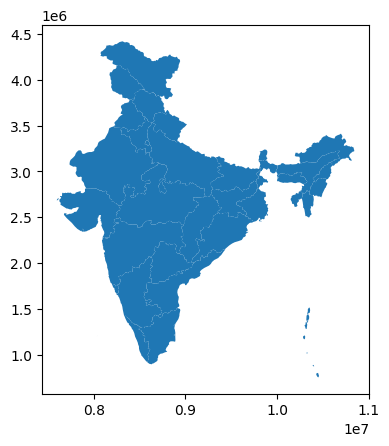

In [40]:
merged_data['data_frame'].plot()

In [41]:
def CustomPalette(palette_type):
  if palette_type.lower()=='OrRd'.lower():
    palette = OrRd[9]
    palette = palette[::-1]
  else:
    palette = brewer['Oranges']
    palette = palette[::-1]
  return palette

In [42]:
def CustomHoverTool(enable_advancedStats, custom_hovertool):
  advancedStats_hover=HoverTool(tooltips ="""<strong><font face="Arial" size="3">@state</font></strong> <br>
                                             <font face="Arial" size="3">Cases: @total_cases</font><br>
                                             <font face="Arial" size="3">Deaths: @deaths </font>
                                             <hr>
                                             <font face="Arial" size="3">Forecast (+1 day cases): @preds_cases </font>""")

  simpleStats_hover=HoverTool(tooltips ="""<strong><font face="Arial" size="3">@state</font></strong> <br>
                                           <font face="Arial" size="3">Cases: @total_cases</font><br>
                                           <font face="Arial" size="3">Deaths: @deaths </font>""")

  standard_hover = HoverTool(tooltips = [('State','@state'),
                                         ('Cases', '@total_cases'),
                                         #('Discharged/migrated', '@discharged'),
                                         ('Deaths', '@deaths')])
  
  if enable_advancedStats:
    hover = advancedStats_hover
  elif custom_hovertool:
    hover  = simpleStats_hover
  else:
    hover = standard_hover
  return hover

In [43]:
def MapOverlayFormatter(map_overlay):
  if map_overlay:
    xmin = 8450000
    xmax = 10000000
    ymin = 850000
    ymax = 4550000
    
    return xmin, xmax, ymin, ymax

In [44]:
def geographic_overlay(plt, 
                       geosourceJson=None,
                       colorBar=None,
                       colorMapper=None,
                       colorMode='',
                       hoverTool=None,
                       mapOverlay=True,
                       enableTapTool=False,
                       enableToolbar=True):
  if mapOverlay:
    wmts = WMTSTileSource(url="http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png")
    plt.add_tile(wmts)
    plt.xaxis.axis_label = 'longitude'
    plt.yaxis.axis_label = 'latitude'
  
  plt.xgrid.grid_line_color = None
  plt.ygrid.grid_line_color = None
  plt.axis.visible = False
  plt.patches('xs','ys', 
              source = geosourceJson, 
              fill_color = {'field' : colorMode, 
                            'transform' : colorMapper},
              line_color = 'purple', 
              line_width = 0.5, 
              fill_alpha = 0.85)
  plt.add_layout(colorBar, 'right')
  plt.add_tools(hoverTool)
  if enableTapTool:
    plt.add_tools(TapTool())
  if enableToolbar:
    plt.toolbar.autohide = True
  if plt.title is not None:
    plt.title.text_font_size = '30pt'
  return plt

In [45]:
def covid19_plot(covid19_geosource, 
                 input_df=None,
                 input_field=None,
                 plot_title=None,
                 map_overlay=True,
                 palette_type='OrRd',
                 custom_hovertool=True,
                 enable_advancedStats=False,
                 enable_toolbar=False):
  
  palette = CustomPalette(palette_type)
  color_mapper = LinearColorMapper(palette=palette, 
                                   low=0, 
                                   high=int(10*(np.ceil(np.max(input_df[input_field].values)/10))))
  format_tick = NumeralTickFormatter(format=str(input_df[input_field].values.astype('int')))
  color_bar = ColorBar(color_mapper=color_mapper, 
                       label_standoff=11, 
                       formatter=format_tick,
                       border_line_color=None, 
                       major_label_text_font_size='16px',
                       location = (0, 0))
  xmin, xmax, ymin, ymax = MapOverlayFormatter(map_overlay)
  hover = CustomHoverTool(enable_advancedStats, custom_hovertool)

  plt = figure(title = plot_title,
               x_range=(xmin, xmax) if map_overlay else None,
               y_range=(ymin, ymax) if map_overlay else None,
               tools='save' if enable_toolbar else '', 
               min_height = 640, min_width = 640,
               toolbar_location = 'left' if enable_toolbar else None,
               lod_factor=int(1e7),
               lod_threshold=int(2),
               output_backend="webgl")
  
  plt = geographic_overlay(plt, 
                           geosourceJson=covid19_geosource,
                           colorBar=color_bar,
                           colorMapper=color_mapper,
                           colorMode=input_field,
                           hoverTool=hover,
                           mapOverlay=map_overlay,
                           enableToolbar=enable_toolbar,
                           enableTapTool=True if enable_advancedStats else False)
  
  return plt

In [46]:
from bokeh.models import ColumnDataSource, RadioButtonGroup

## Generate COVID19 plot

In [47]:
covid19_geosource=GeoJSONDataSource(geojson=merged_json)
plot_title='COVID19 outbreak in India'
app_title='COVID19 India'

In [48]:
_covid19_plot = covid19_plot(covid19_geosource, 
                             input_df=covid19_data,
                             input_field='deaths',
                             plot_title=plot_title)

In [49]:
curdoc().title=app_title
covid19_layout = column(_covid19_plot)
curdoc().add_root(covid19_layout)

## Display the interactive COVID19 map for India
This generates an interactive COVID19 India outbreak map, within the notebook.
![Bokeh static output](https://raw.githubusercontent.com/MoadComputer/covid19-visualization/main/examples/COVID19_India_Bokeh_output.png)

The image above is a static screenshot of the Bokeh output. It shows the hover-tool functionality and the save-tool for generating a ```.png``` output. By hovering (devices with a pointer) or single-tapping (touch devices) over the corresponding states, an exapnded summary of COVID19 outbreak in India is displayed.

In [50]:
output_notebook()
show(covid19_layout)

Loading BokehJS ...

# Part 02 - Forecasting

## Import dependent libraries

In [51]:
import os
import gc
import glob
import random
import shutil
import datetime
import tensorflow
import tensorflow as tf

import numpy as np
import pandas as pd
import bokeh.plotting as bk
import matplotlib.pyplot as plt
import tensorflow.keras.applications.efficientnet as efn

from tqdm import tqdm
from bokeh.models import HoverTool
from scipy.interpolate import interp1d
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import ConvLSTM2D, Dense, Activation, Flatten

2025-07-24 08:14:11.915397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753344852.210438      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753344852.297748      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [52]:
if os.path.exists('/kaggle/working/'):
  kaggle_kernel_mode=True  
  print('Kaggle kernel mode detected ...')  

Kaggle kernel mode detected ...


## Missing csv file imputation
The missing csv file [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)) is created by filling the data from the day prior to the missing datapoint.

In [53]:
csv_archive_dir = f'{WORKING_DIR}/covid19-visualization/data/Coronavirus_stats/India/archives/'
sorted_csv_file_list = sorted(os.listdir(csv_archive_dir))
csv_file_prefix = 'COVID19_India_statewise_'
oldest_csv_file = sorted_csv_file_list[0]
newest_csv_file = sorted_csv_file_list[-1]
csv_file_id_format = '%Y%m%d'
print(f'Found oldest case statistics file in the repo: {oldest_csv_file} ...')
print(f'Found the most recent statistics file in the repo: {newest_csv_file} ...')
oldest_csv_file_date = oldest_csv_file.replace(csv_file_prefix,'').replace('.csv','')
oldest_csv_file_date = datetime.datetime.strptime(oldest_csv_file_date, csv_file_id_format)
newest_csv_file_date = data_date # newest_csv_file.replace(csv_file_prefix,'').replace('.csv','')
newest_csv_file_date = datetime.datetime.strptime(newest_csv_file_date, csv_file_id_format)
for i in range((newest_csv_file_date - oldest_csv_file_date).days):
    csv_file_id = (oldest_csv_file_date + datetime.timedelta(days=i)).strftime(csv_file_id_format)
    csv_file = os.path.join(csv_archive_dir, csv_file_prefix + csv_file_id + '.csv')
    if not os.path.exists(csv_file):
        assert i > 1, 'Encountered an unknown error during imputation ...'
        prev_csv_file_id = (oldest_csv_file_date + datetime.timedelta(days=i - 1)).strftime(csv_file_id_format)
        prev_csv_file = os.path.join(csv_archive_dir, csv_file_prefix + prev_csv_file_id + '.csv')
        #print(f'Missing csv file: {csv_file}')
        shutil.copyfile(prev_csv_file, csv_file)
        if not os.path.exists(csv_file):
            print(f'Failed to create imputed csv file: {csv_file} ...')

Found oldest case statistics file in the repo: COVID19_India_statewise_20200730.csv ...
Found the most recent statistics file in the repo: COVID19_India_statewise_20250724.csv ...


## Imputing missing predictions
For imputing the predictions [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)), the predicted values from the day prior to the missing datapoint is used to fill the missing datapoint.

In [54]:
#/kaggle/working/covid19-visualization/data/Coronavirus_stats/India/experimental/archives/output_preds_20200419.csv
pred_archive_dir = f'{WORKING_DIR}/covid19-visualization/data/Coronavirus_stats/India/experimental/archives/'
sorted_pred_file_list = sorted(os.listdir(pred_archive_dir))
pred_file_prefix = 'output_preds_'
oldest_pred_file = sorted_pred_file_list[0]
newest_pred_file = sorted_pred_file_list[-1]
pred_file_id_format = '%Y%m%d'
print(f'Found oldest case statistics file in the repo: {oldest_pred_file} ...')
print(f'Found the most recent statistics file in the repo: {newest_pred_file} ...')
oldest_pred_file_date = oldest_pred_file.replace(pred_file_prefix,'').replace('.csv','')
oldest_pred_file_date = datetime.datetime.strptime(oldest_pred_file_date, pred_file_id_format)
newest_pred_file_date = data_date # newest_pred_file.replace(pred_file_prefix,'').replace('.csv','')
newest_pred_file_date = datetime.datetime.strptime(newest_pred_file_date, pred_file_id_format)
for i in range((newest_pred_file_date - oldest_pred_file_date).days + 1):
    pred_file_id = (oldest_pred_file_date + datetime.timedelta(days=i)).strftime(pred_file_id_format)
    pred_file = os.path.join(pred_archive_dir, pred_file_prefix + pred_file_id + '.csv')
    if not os.path.exists(pred_file):
        assert i > 1, 'Encountered an unknown error during imputation ...'
        prev_pred_file_id = (oldest_pred_file_date + datetime.timedelta(days=i - 1)).strftime(pred_file_id_format)
        prev_pred_file = os.path.join(pred_archive_dir, pred_file_prefix + prev_pred_file_id + '.csv')
        #print(f'Missing pred file: {pred_file}')
        shutil.copyfile(prev_pred_file, pred_file)
        if not os.path.exists(pred_file):
            print(f'Failed to create imputed pred file: {pred_file} ...')

Found oldest case statistics file in the repo: output_preds_20200419.csv ...
Found the most recent statistics file in the repo: output_preds_20250724.csv ...


In [55]:
def get_available_gpus():
  local_device_protos=device_lib.list_local_devices()
  return [x.name for x in local_device_protos if x.device_type=='GPU']
available_gpus=get_available_gpus()
gpus=True if len(available_gpus)>=1else False
if gpus:
  print('Available GPUS: {} ...'.format(available_gpus))

<>:5: SyntaxWarning: invalid decimal literal
<>:5: SyntaxWarning: invalid decimal literal
/tmp/ipykernel_13/125826107.py:5: SyntaxWarning: invalid decimal literal
  gpus=True if len(available_gpus)>=1else False
2025-07-24 08:14:30.687822: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [56]:
India_stats = pd.read_csv('https://raw.githubusercontent.com/MoadComputer/covid19-visualization/main/data/Coronavirus_stats/India/Population_stats_India_statewise.csv')
del India_stats['ID']
India_stats=apply_corrections(India_stats)
India_stats.head()

state  population      area    hdi     gdp
0               Andhra Pradesh    49386799  160205.0  0.650  151173
1  Andaman and Nicobar Islands      380520    8250.0  0.739  159664
2            Arunachal Pradesh     1382611   83743.0  0.617  138401
3                        Assam    31169272   78438.0  0.605   82078
4                        Bihar   104099452   94163.0  0.566   43822

In [57]:
total_cases=covid19_data['total_cases'].sum()
total_deaths=covid19_data['deaths'].sum()

print(total_cases)
print(total_deaths)

29880
167


In [58]:
total_population=India_stats['population'].sum()
total_area=India_stats['area'].sum()
affected_population=int(np.ceil(total_population*frac_affected))

print(total_area)
print(total_population)
print(affected_population)

3166123.27
1218556491
365566948


In [59]:
def using_Tokenizer(doc):
    t = Tokenizer()
    t.fit_on_texts(doc)
    #encoded_docs = t.texts_to_sequences(doc)
    encoded_docs = t.texts_to_matrix(doc, mode='count')
    return encoded_docs, t

def using_to_categorical(doc):
    label_encoder = LabelEncoder()
    data = label_encoder.fit_transform(doc)
    decoder_dict={}
    row_decoder_dict={}
    for i in range(len(doc)):
        decoder_dict.update({doc[i]: data[i]})
        row_decoder_dict.update({i: data[i]})
    data = np.array(data)
    encoded = to_categorical(data)
    return encoded, label_encoder, decoder_dict, row_decoder_dict

def invert_encoding(input_num, row_decoder_dict=None,label_encoder=None, onehot_encoded=None):
    row_num=row_decoder_dict[input_num]
    print(row_num)
    inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[row_num, :])])
    return inverted

In [60]:
archive_dir=os.path.join(WORKING_DIR, 'covid19-visualization/data/Coronavirus_stats/India/archives/')
train_file_list=glob.glob('{}/*.csv'.format(archive_dir))
train_file_list.sort()

In [61]:
assert len(train_file_list) > 1, 'No files to train ...'

In [62]:
def preprocess_dataframe(input_df, label_mode=False):
  input_df['deaths']=input_df['deaths']/input_df['deaths'].sum()
  input_df['total_cases']=input_df['total_cases']/input_df['total_cases'].sum()
  if not label_mode:
    input_df['population']=input_df['population']/input_df['population'].sum()#np.max(stats_df['population'])
    input_df['area']=input_df['area']/input_df['area'].sum()#np.max(stats_df['area'])
    input_df['hdi']=input_df['hdi']/np.max(input_df['hdi'])
    input_df['gdp']=input_df['gdp']/np.max(input_df['gdp'])
  return input_df

In [63]:
def data_generator(train_file_list,
                   window_size=3,
                   look_ahead=3,
                   batch_size=10,
                   prediction_target='deaths',
                   prediction_statesList=['Kerala'],
                   shuffle=True,
                   training_mode=True,
                   eval_mode=False,
                   verbose=False): 
    gc.collect()
    rng = random.SystemRandom()
    counter=0
    while 1:
        X=[]
        if training_mode:
            y=[]
            
        for i in range(batch_size):
            if len(train_file_list)==1:
                sys.exit('Insufficient number of training files ...')
                
            if training_mode:
              window_size=len(train_file_list)-look_ahead if len(train_file_list)<(window_size+look_ahead) else window_size
            else:
              look_ahead=0
              
            if window_size<1:
              sys.exit('Insufficient number of training files for a window size: {} to look ahead: {} days ...'.format(window_size, look_ahead))

            r=0
            j=window_size
            if training_mode and shuffle:
              r=rng.randint(0,(len(train_file_list)-(window_size+look_ahead+1)))            
                        
            df_list=[]
            for k in range(j+look_ahead):
                file_path=train_file_list[k+r]
                if verbose:
                  print('Reading input data from: {} ...'.format(file_path))
                if not os.path.exists(file_path):
                    sys.exit('{} does not exist ...'.format(file_path))
                
                if k < j and training_mode:
                    df = pd.read_csv(file_path)
                    try:
                      del df['active_cases']
                    except:
                      pass
                    df = apply_corrections(df)
                    df_list.append(df)
                    if k == (j-1):
                      output_ref_df = pd.read_csv(file_path)
                      try:
                        del df['active_cases']
                      except:
                        pass
                      output_ref_df = apply_corrections(output_ref_df)
                elif k == (j+look_ahead-1) and training_mode:
                    output_stats_df = pd.read_csv(file_path)
                    try:
                      del df['active_cases']
                    except:
                      pass
                    output_stats_df = apply_corrections(output_stats_df)
                elif not training_mode:
                    if k<j+1:
                      df = pd.read_csv(file_path)
                      try:
                        del df['active_cases']
                      except:
                        pass
                      df = apply_corrections(df)
                      df_list.append(df)

            stats_df_list = []
            for df in df_list:
                df=pd.merge(India_stats, df, on='state', how='left')
                try:
                    del df['active_cases']
                except:
                    pass
                df=df.fillna(0)
                df=apply_corrections(df)
                stats_df_list.append(df)

            data_df_list = []
            encoded_states_list=[]
            for stats_df in stats_df_list:   
                stats_df=preprocess_dataframe(stats_df)
                del stats_df['discharged']
                del stats_df['ID']
                doc=list(stats_df['state'].values)
                del stats_df['state']
                
                data_df_list.append(stats_df.to_numpy())
                onehot_encoded, label_encoder, decoder_dict, row_decoder_dict=using_to_categorical(doc)
                encoded_states_list.append(onehot_encoded)

            if training_mode:
                output_stats_df=output_stats_df.fillna(0)
                output_ref_df=output_ref_df.fillna(0)

                y_list=[]
                for prediction_state in prediction_statesList:
                  y_=output_stats_df.loc[output_stats_df['state'] == prediction_state, prediction_target]
                  y_ref=output_ref_df.loc[output_ref_df['state'] == prediction_state, prediction_target]
                  
                  if y_.empty:
                    y_=np.asarray([0.0]).astype(np.float32)
                  else:
                    try:
                      y_=np.asarray(y_.values).astype(np.float32)
                    except:
                      y_=np.asarray(y_).astype(np.float32)

                  if y_ref.empty:
                    y_ref=np.asarray([0.0]).astype(np.float32)
                  else:
                    try:
                      y_ref=np.asarray(y_ref.values).astype(np.float32)
                    except:
                      y_ref=np.asarray(y_ref).astype(np.float32)
                    
                  if not eval_mode:
                    if y_.item()!=np.asarray([0.0]).astype(np.float32):
                      y_=np.asarray(y_ref/y_).astype(np.float32)
                    else:
                      y_=np.asarray([1.0]).astype(np.float32)
                  y_list.append(y_)
                y.append(np.asarray(y_list).astype(np.float32))

            X_=np.concatenate((np.asarray(data_df_list).astype(np.float32), 
                               np.asarray(encoded_states_list).astype(np.float32)),
                               axis=2)
            X.append(X_)

        y=np.asarray(y).astype(np.float32) if training_mode else None
        X=np.asarray(X)
        yield X,y

        if counter >= batch_size:
            counter = 0

In [64]:
if verbose:
    print ("===using Keras Tokenizer for OneHotEncoding===")
    print (encoded_text)
    print ()
    print ("===using Keras to_categorical for OneHotEncoding===")
    print (onehot_encoded)
    print ()
    print (invert_encoding(np.argmax(encoded_states_list[0][28]), 
                                     row_decoder_dict=row_decoder_dict,
                                     label_encoder=label_encoder,
                                     onehot_encoded=onehot_encoded))

In [65]:
class bayesian_dropout(tensorflow.keras.layers.Dropout):
    """Applies a Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self,
                 rate, 
                 training=None, 
                 noise_shape=None, 
                 seed=None, 
                 **kwargs):
        super(bayesian_dropout, self).__init__(rate, **kwargs)

        self.training = training
        self.rate = rate
        self.noise_shape = noise_shape
        self.seed = seed

        self.dropout_layer = tf.keras.layers.Dropout(
                                 self.rate, 
                                 noise_shape=self.noise_shape, 
                                 seed=self.seed
                             )
        
    def call(self, inputs, training=None):
        inputs = self.dropout_layer(inputs, training=self.training)
        return inputs

In [66]:
def convlstm(model,layer_depth=4,enable_bacthnorm=False):
  for i in range(layer_depth):
    model.add(tensorflow.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    if enable_bacthnorm:
      model.add(tensorflow.keras.layers.BatchNormalization())
  model.add(tensorflow.keras.layers.Flatten())
  return model

In [67]:
def covid19_model(input_tensorShape=(window_size,36,42),
                  cortical_filter_height=75,
                  cortical_filter_width=75,
                  cortical_filter_channels=3,
                  input_layer_units=32,
                  prediction_size=1,
                  dropout=0.25,
                  backbone='vgg16',
                  enable_pooling=False,
                  enable_dense_input=True,
                  enable_basemodelRNN=False,
                  enable_bayesian_inference=False):
    gc.collect()
    tensorflow.keras.backend.clear_session()
    model = Sequential()
    if enable_dense_input:
      model.add(tensorflow.keras.layers.Dense(input_layer_units, 
                                              activation='relu',
                      input_shape=input_tensorShape))
    else:
      model.add(tensorflow.keras.layers.Conv2D(64, 
                                               kernel_size=(1, 1), 
                                               activation='relu', 
                                               input_shape=input_tensorShape))
    if not enable_basemodelRNN:
        model.add(Flatten())
    model.add(bayesian_dropout(rate=dropout, 
                              training=enable_bayesian_inference,
                              name='input_bayesian_dropout'))
    if enable_basemodelRNN:
        model.add(tensorflow.keras.layers.TimeDistributed(
            Dense(cortical_filter_height*cortical_filter_width*cortical_filter_channels, 
                    activation='sigmoid')))
    else:
        model.add(Dense(cortical_filter_height*cortical_filter_width*cortical_filter_channels, 
                    activation='sigmoid'))
    model.add(tensorflow.keras.layers.BatchNormalization(dtype=np.float32))
    model.add(bayesian_dropout(rate=dropout, 
                              training=enable_bayesian_inference,
                              name='corticalInput_bayesian_dropout'))
    if enable_basemodelRNN:
        resize_shape=(cortical_filter_height,
                      cortical_filter_width,
                      cortical_filter_channels,
                      input_tensorShape[1]*window_size)
    else:
        resize_shape=(cortical_filter_height,
                      cortical_filter_width,
                      cortical_filter_channels)
    model.add(tensorflow.keras.layers.Reshape(target_shape =resize_shape,
                                              dtype=np.float32,
                                              name='reshape_layer'))
    if str(backbone).lower() == 'vgg16':
      backbone=tensorflow.keras.applications.vgg16.VGG16(include_top=False, 
                                                         weights=None, 
                                                         input_shape=(cortical_filter_height,
                                                                      cortical_filter_width,
                                                                      cortical_filter_channels))
    elif str(backbone).lower() == 'vgg19':
      backbone=tensorflow.keras.applications.vgg19.VGG19(include_top=False, 
                                                         weights=None, 
                                                         input_shape=(cortical_filter_height,
                                                                      cortical_filter_width,
                                                                      cortical_filter_channels))
    elif str(backbone).lower() == 'xception':
      backbone=tensorflow.keras.applications.xception.Xception(include_top=False, 
                                                               weights=None, 
                                                               input_shape=(cortical_filter_height,
                                                                            cortical_filter_width,
                                                                            cortical_filter_channels))
    elif str(backbone).lower() == 'resnet50v2':
      backbone=tensorflow.keras.applications.ResNet50V2(weights=None, 
                                                      include_top=False,
                                                      input_shape=(cortical_filter_height,
                                                                   cortical_filter_width,
                                                                   cortical_filter_channels))
    elif str(backbone).lower() == 'resnet101v2':
      backbone=tensorflow.keras.applications.ResNet101V2(weights=None, 
                                                      include_top=False,
                                                      input_shape=(cortical_filter_height,
                                                                   cortical_filter_width,
                                                                   cortical_filter_channels))
    elif str(backbone).lower() == 'resnet152v2':
      backbone=tensorflow.keras.applications.ResNet152V2(weights=None, 
                                                      include_top=False,
                                                      input_shape=(cortical_filter_height,
                                                                   cortical_filter_width,
                                                                   cortical_filter_channels))
    elif str(backbone).lower() == 'resnet50':
      backbone=tensorflow.keras.applications.ResNet50(weights=None, 
                                                      include_top=False,
                                                      input_shape=(cortical_filter_height,
                                                                   cortical_filter_width,
                                                                   cortical_filter_channels))
    elif str(backbone).lower() == 'resnet101':
      backbone=tensorflow.keras.applications.ResNet101(weights=None, 
                                                      include_top=False,
                                                      input_shape=(cortical_filter_height,
                                                                   cortical_filter_width,
                                                                   cortical_filter_channels))
    elif str(backbone).lower() == 'resnet152':
      backbone=tensorflow.keras.applications.ResNet152(weights=None, 
                                                      include_top=False,
                                                      input_shape=(cortical_filter_height,
                                                                   cortical_filter_width,
                                                                   cortical_filter_channels))
    elif str(backbone).lower() == 'inceptionv3':  
      backbone=tensorflow.keras.applications.InceptionV3(weights=None, 
                                                         include_top=False,
                                                         input_shape=(cortical_filter_height,
                                                                      cortical_filter_width,
                                                                      cortical_filter_channels))
    elif str(backbone).lower() == 'inceptionresnetv2':
      backbone=tensorflow.keras.applications.InceptionResNetV2(weights=None, 
                                                      include_top=False,
                                                      input_shape=(cortical_filter_height,
                                                                   cortical_filter_width,
                                                                   cortical_filter_channels))
    elif str(backbone).lower() == 'efficientnetb0':
      backbone = efn.EfficientNetB0(weights=None, 
                                    include_top=False,
                                    input_shape=(cortical_filter_height, 
                                                 cortical_filter_width, 
                                                 cortical_filter_channels))
    elif str(backbone).lower() == 'efficientnetb1':  
      backbone = efn.EfficientNetB1(weights=None, 
                                    include_top=False,
                                    input_shape=(cortical_filter_height, 
                                                cortical_filter_width, 
                                                cortical_filter_channels))
    elif str(backbone).lower() == 'efficientnetb2':  
      backbone = efn.EfficientNetB2(weights=None, 
                                    include_top=False,
                                    input_shape=(cortical_filter_height, 
                                                cortical_filter_width, 
                                                cortical_filter_channels))
    elif str(backbone).lower() == 'efficientnetb3':
      backbone = efn.EfficientNetB3(weights=None, 
                                    include_top=False,
                                    input_shape=(cortical_filter_height, 
                                                 cortical_filter_width, 
                                                 cortical_filter_channels))
    elif str(backbone).lower() == 'efficientnetb4':
      backbone = efn.EfficientNetB4(weights=None, 
                                    include_top=False,
                                    input_shape=(cortical_filter_height, 
                                                 cortical_filter_width, 
                                                 cortical_filter_channels)) 
    elif str(backbone).lower() == 'efficientnetb5':
      backbone = efn.EfficientNetB5(weights=None, 
                                    include_top=False,
                                    input_shape=(cortical_filter_height, 
                                                 cortical_filter_width, 
                                                 cortical_filter_channels))
    elif str(backbone).lower() == 'efficientnetb6':
      backbone = efn.EfficientNetB5(weights=None, 
                                    include_top=False,
                                    input_shape=(cortical_filter_height, 
                                                 cortical_filter_width, 
                                                 cortical_filter_channels))   
    elif str(backbone).lower() == 'efficientnetb7':
      backbone = efn.EfficientNetB7(weights=None, 
                                    include_top=False,
                                    input_shape=(cortical_filter_height, 
                                                 cortical_filter_width, 
                                                 cortical_filter_channels))
    elif str(backbone).lower() == 'densenet121':
      backbone = tensorflow.keras.applications.densenet.DenseNet121(weights=None, 
                                                         include_top=False,
                                                         input_shape=(cortical_filter_height,
                                                                      cortical_filter_width,
                                                                      cortical_filter_channels))
    elif str(backbone).lower() == 'densenet169':
      backbone = tensorflow.keras.applications.densenet.DenseNet169(weights=None, 
                                                         include_top=False,
                                                         input_shape=(cortical_filter_height,
                                                                      cortical_filter_width,
                                                                      cortical_filter_channels))
    elif str(backbone).lower() == 'densenet201':
      backbone = tensorflow.keras.applications.densenet.DenseNet201(weights=None, 
                                                         include_top=False,
                                                         input_shape=(cortical_filter_height,
                                                                      cortical_filter_width,
                                                                      cortical_filter_channels))
    elif str(backbone).lower() == 'nasnetlarge': 
      backbone = tensorflow.keras.applications.nasnet.NASNetLarge(weights=None, 
                                                                  include_top=False,
                                                                  input_shape=(cortical_filter_height,
                                                                               cortical_filter_width,
                                                                               cortical_filter_channels)) 
    elif str(backbone).lower() == 'nasnetmobile':
      backbone = tensorflow.keras.applications.nasnet.NASNetMobile(weights=None, 
                                                                  include_top=False,
                                                                  input_shape=(cortical_filter_height,
                                                                               cortical_filter_width,
                                                                               cortical_filter_channels))
    elif str(backbone).lower() == 'mobilenetv2':
      backbone = tensorflow.keras.applications.mobilenet_v2.MobileNetV2(weights=None, 
                                                                        include_top=False,
                                                                        input_shape=(cortical_filter_height,
                                                                                    cortical_filter_width,
                                                                                    cortical_filter_channels))
    elif str(backbone).lower() == 'mobilenet':
      backbone = tensorflow.keras.applications.mobilenet.MobileNet(weights=None, 
                                                                   include_top=False,
                                                                   input_shape=(cortical_filter_height,
                                                                                cortical_filter_width,
                                                                                cortical_filter_channels))
    try:
      model.add(backbone)
    except:
      if backbone is not None:
        model=backbone(model)

    if enable_pooling:
      model.add(tensorflow.keras.layers.BatchNormalization(dtype=np.float32, name='fc_bn'))
      model.add(tensorflow.keras.layers.GlobalAveragePooling2D(name='fc_gloablAveragePooling2D'))
    model.add(bayesian_dropout(rate=dropout, 
                               training=enable_bayesian_inference,
                               name='fc_bayesian_dropout'))
    #model.add(Dense(64, activation='sigmoid', name='fc_dense_256'))
    model.add(Dense(16, activation='sigmoid', name='fc_dense_16'))
    model.add(bayesian_dropout(rate=dropout, 
                               training=enable_bayesian_inference,
                               name='preds_bayesian_dropout'))
    model.add(Dense(prediction_size, activation='sigmoid', name='prediction'))
    model.compile(loss='mse', optimizer='Adam')
    return model

In [68]:
convlstm_convInput_model = covid19_model(backbone=convlstm,
                               enable_dense_input=False,
                               enable_basemodelRNN=True)
convlstm_denseInput_model = covid19_model(backbone=convlstm,
                               enable_dense_input=True,
                               enable_basemodelRNN=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [69]:
print(convlstm_convInput_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 7, 36, 64)      │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_bayesian_dropout          │ (None, 7, 36, 64)      │             0 │
│ (bayesian_dropout)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 7, 36, 16875)   │     1,096,875 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 36, 16875)   │        67,500 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ corticalInput_bayesian_dropout  │ (None, 7, 36, 16875)   │             0 │
│ (bayesian_dropout)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (Reshape)         │ (None, 75, 75, 3, 252) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 75, 75, 3, 40)  │       420,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 75, 75, 3, 40)  │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 75, 75, 3, 40)  │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 75, 75, 3, 40)  │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 675000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_bayesian_dropout             │ (None, 675000)         │             0 │
│ (bayesian_dropout)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_dense_16 (Dense)             │ (None, 16)             │    10,800,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds_bayesian_dropout          │ (None, 16)             │             0 │
│ (bayesian_dropout)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,733,880 (48.58 MB)

 Trainable params: 12,700,130 (48.45 MB)

 Non-trainable params: 33,750 (131.84 KB)

None


In [70]:
print(convlstm_denseInput_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 7, 36, 32)      │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_bayesian_dropout          │ (None, 7, 36, 32)      │             0 │
│ (bayesian_dropout)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 7, 36, 16875)   │       556,875 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 36, 16875)   │        67,500 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ corticalInput_bayesian_dropout  │ (None, 7, 36, 16875)   │             0 │
│ (bayesian_dropout)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (Reshape)         │ (None, 75, 75, 3, 252) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 75, 75, 3, 40)  │       420,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 75, 75, 3, 40)  │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 75, 75, 3, 40)  │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 75, 75, 3, 40)  │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 675000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_bayesian_dropout             │ (None, 675000)         │             0 │
│ (bayesian_dropout)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_dense_16 (Dense)             │ (None, 16)             │    10,800,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds_bayesian_dropout          │ (None, 16)             │             0 │
│ (bayesian_dropout)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,192,504 (46.51 MB)

 Trainable params: 12,158,754 (46.38 MB)

 Non-trainable params: 33,750 (131.84 KB)

None


In [71]:
def make_preds_list(input_file_list, window_size, look_ahead):
  preds_file_list=input_file_list[-(window_size+look_ahead-1):]
  preds_correction_fileList=input_file_list[-(window_size+look_ahead):]
  return preds_file_list, preds_correction_fileList

In [72]:
def make_predictions(X,
                     input_model=None,
                     eval_steps=5,
                     bayesianInference_steps=10,
                     enable_bayesian_inference=True):  
  if enable_bayesian_inference:
    preds_=[]
    for i in tqdm(range(eval_steps)):
      preds_avg=[]
      for i in range(bayesianInference_steps):
        _preds=abs(input_model.predict(X))
        preds_avg.append(_preds)
      preds_.append(np.mean(preds_avg, axis=0))
    preds=np.mean(preds_, axis=0)
  else:
    preds=input_model.predict(X)
  return preds

In [73]:
covid19_data = apply_corrections(covid19_data)

In [74]:
prediction_target='total_cases'
prediction_state_list=list(covid19_data['state'].values)

In [75]:
preds_df=covid19_data.copy()
preds_df=apply_corrections(preds_df)
del preds_df['discharged']
del preds_df['deaths']
del preds_df['ID']
try:
  del preds_df['active_cases']
except:
  print('Failed to remove active_cases column')  

Failed to remove active_cases column


In [76]:
for column in preds_df.columns:
  if column != 'state' and column != 'preds_cases' and column !='preds_cases_3' and column !='preds_cases_7':
    del preds_df['{}'.format(column)]
if len(list(set(list(preds_df.columns))-set(['preds_cases_7'])))==len(list(preds_df.columns)):
  sLength=len(preds_df)
  preds_df.loc[:,'preds_cases_7'] = pd.Series(np.random.randn(sLength), index=preds_df.index)
if len(list(set(list(preds_df.columns))-set(['preds_cases_3'])))==len(list(preds_df.columns)):
  sLength=len(preds_df)
  preds_df.loc[:,'preds_cases_3'] = pd.Series(np.random.randn(sLength), index=preds_df.index)
if len(list(set(list(preds_df.columns))-set(['preds_cases'])))==len(list(preds_df.columns)):
  sLength=len(preds_df)
  preds_df.loc[:,'preds_cases'] = pd.Series(np.random.randn(sLength), index=preds_df.index)

## Train forecasting model

In [77]:
enable_training = True

In [78]:
 if enable_training:
    for BACKBONE in tqdm(BACKBONE_LIST):
      window_size_=window_size
      if BACKBONE.lower()=='ConvLSTM_convInput'.lower() or BACKBONE.lower()=='ConvLSTM_denseInput'.lower():
        window_size_=20
      print('\n')
      print('Model parameters: \nModel type: {} \nWindow size: {} \n Batch size: {}'.format(BACKBONE,
                                                                                            window_size_,
                                                                                            batch_size))
      for look_ahead in LOOK_AHEAD_LIST:
        if BACKBONE.lower() == 'convlstm_convinput':
          model=convlstm_convInput_model
        elif BACKBONE.lower() == 'convlstm_denseinput':
          model=convlstm_denseInput_model
        else:
          model = covid19_model(backbone=BACKBONE,
                                enable_pooling=True,
                                prediction_size=len(prediction_state_list),
                                enable_dense_input=False,
                                enable_bayesian_inference=enable_bayesian_inference)
        
        model_id = MODEL_ID_DICT[BACKBONE]
        weights_filename = f'covid19_india_forecasting_{look_ahead}_{model_id}.h5'
        saved_weights_dir = '/kaggle/input/covid19-india-forecasts-aggregation-v2'
        if not os.path.exists(saved_weights_dir):
          saved_weights_dir = '/kaggle/input/k/remananr/covid19-india-forecasts-aggregation-v2'
        saved_weights = f'{saved_weights_dir}/{weights_filename}'
        output_weights = f'{WORKING_DIR}{weights_filename}'
        
        if os.path.exists(saved_weights):
          model.load_weights(saved_weights)
          print(f'Loaded saved weights from: {saved_weights} ...')

        model.fit(data_generator(train_file_list,
                                window_size=window_size,
                                look_ahead=look_ahead,
                                batch_size=batch_size,
                                prediction_target=prediction_target,
                                prediction_statesList=prediction_state_list,
                                training_mode=True),
                  steps_per_epoch=100,
                  epochs=EPOCHS,#5 if BACKBONE.lower()=='convlstm_convinput' or BACKBONE.lower()=='convlstm_denseinput' else EPOCHS,
                  verbose=1)

        preds_file_list, preds_correction_fileList=make_preds_list(train_file_list, 
                                                                  window_size, 
                                                                  look_ahead=look_ahead)
        for c_x,c_y in data_generator(preds_correction_fileList,
                                      window_size=window_size,
                                      look_ahead=look_ahead,
                                      batch_size=1,
                                      prediction_target=prediction_target,
                                      prediction_statesList=prediction_state_list,
                                      shuffle=False,
                                      training_mode=True,
                                      eval_mode=True):
            cX=c_x
            cY=c_y
            break
        for x,y in data_generator(preds_file_list,
                                  window_size=window_size,
                                  look_ahead=look_ahead,
                                  batch_size=1,
                                  prediction_target=prediction_target,
                                  prediction_statesList=prediction_state_list,
                                  training_mode=False):
            X=x
            break
    
        preds= make_predictions(X,
                                model,
                                eval_steps=5,
                                bayesianInference_steps=10,
                                enable_bayesian_inference=True)
        preds_list=(cY/preds[0])[0]

        for i in range(len((cY/preds[0])[0])):
          preds_=np.mean(preds_list[i])
          preds_=np.ceil(preds_)
          prediction_state=prediction_state_list[i]
          print('\nPredicted {} for {}: (+{} day) {} vs. current: {}...'.format(prediction_target, 
                                                                                prediction_state, 
                                                                                look_ahead,
                                                                                preds_,
                                                                                cY[0][i]))
          if look_ahead == 1:
            column_id='preds_cases'
          else:
            column_id ='preds_cases_{}'.format(look_ahead)
          print('\n')
          preds_df.loc[preds_df['state'] == prediction_state, column_id]=preds_
        preds_csv_file=f'{WORKING_DIR}output_preds_{BACKBONE}.csv'
        preds_df.to_csv(preds_csv_file)
        del model
        gc.collect()
        tensorflow.keras.backend.clear_session()
 
      for prediction_state in prediction_state_list:
        preds_cases=preds_df.loc[preds_df['state'] == prediction_state, 'preds_cases'].values
        preds_cases_3=preds_df.loc[preds_df['state'] == prediction_state, 'preds_cases_3'].values
        preds_cases_7=preds_df.loc[preds_df['state'] == prediction_state, 'preds_cases_7'].values
        
        if preds_cases > preds_cases_7 and len(LOOK_AHEAD_LIST)==3:
          preds_df.loc[preds_df['state'] == prediction_state, 'preds_cases']=preds_cases_7[0]
          print('Changed +1 day forecast for {} from: {} to: {}'.format(prediction_state,
                                                                       preds_cases[0],
                                                                       preds_cases_7[0]))
          preds_cases=preds_df.loc[preds_df['state'] == prediction_state, 'preds_cases'].values
        
        if preds_cases_3 > preds_cases_7 and len(LOOK_AHEAD_LIST)==3:
          preds_df.loc[preds_df['state'] == prediction_state, 'preds_cases_3']=preds_cases_7[0]
          print('Reset +3 days forecast for {} from: {} to: {}'.format(prediction_state,
                                                                       preds_cases_3[0],
                                                                       preds_cases_7[0]))
          preds_cases_3=preds_df.loc[preds_df['state'] == prediction_state, 'preds_cases_3'].values
            
        if preds_cases > preds_cases_3 and len(LOOK_AHEAD_LIST)==3:
          preds_df.loc[preds_df['state'] == prediction_state, 'preds_cases']=preds_cases_3[0]
          print('Reset +1 day forecast for {} from: {} to: {}'.format(prediction_state,
                                                                      preds_cases,
                                                                      preds_cases_3[0]))
            
        
      preds_df.to_csv(preds_csv_file)

  0%|          | 0/2 [00:00<?, ?it/s]



Model parameters: 
Model type: ConvLSTM_convInput 
Window size: 20 
 Batch size: 16


Loaded saved weights from: /kaggle/input/covid19-india-forecasts-aggregation-v2/covid19_india_forecasting_1_ConvIn.h5 ...


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1:07:29 41s/step - loss: 1.3744e-05

  2/100 ━━━━━━━━━━━━━━━━━━━━ 37:59 23s/step - loss: 1.3156e-05  

  3/100 ━━━━━━━━━━━━━━━━━━━━ 38:15 24s/step - loss: 1.2650e-05

  4/100 ━━━━━━━━━━━━━━━━━━━━ 37:48 24s/step - loss: 1.2795e-05

  5/100 ━━━━━━━━━━━━━━━━━━━━ 37:19 24s/step - loss: 1.4898e-05

  6/100 ━━━━━━━━━━━━━━━━━━━━ 36:36 23s/step - loss: 1.5930e-05

  7/100 ━━━━━━━━━━━━━━━━━━━━ 36:04 23s/step - loss: 1.7709e-05

  8/100 ━━━━━━━━━━━━━━━━━━━━ 35:42 23s/step - loss: 1.8718e-05

  9/100 ━━━━━━━━━━━━━━━━━━━━ 35:10 23s/step - loss: 1.9398e-05

 10/100 ━━━━━━━━━━━━━━━━━━━━ 34:50 23s/step - loss: 3.8571e-05

 11/100 ━━━━━━━━━━━━━━━━━━━━ 34:27 23s/step - loss: 5.2583e-05

 12/100 ━━━━━━━━━━━━━━━━━━━━ 33:58 23s/step - loss: 6.2971e-05

 13/100 ━━━━━━━━━━━━━━━━━━━━ 33:33 23s/step - loss: 7.0928e-05

 14/100 ━━━━━━━━━━━━━━━━━━━━ 33:08 23s/step - loss: 7.7433e-05

 15/100 ━━━━━━━━━━━━━━━━━━━━ 32:40 23s/step - loss: 8.3220e-05

 16/100 ━━━━━━━━━━━━━━━━━━━━ 32:16 23s/step - loss: 8.7933e-05

 17/100 ━━━━━━━━━━━━━━━━━━━━ 32:23 23s/step - loss: 9.1751e-05

 18/100 ━━━━━━━━━━━━━━━━━━━━ 32:00 23s/step - loss: 9.4691e-05

 19/100 ━━━━━━━━━━━━━━━━━━━━ 31:34 23s/step - loss: 1.0021e-04

 20/100 ━━━━━━━━━━━━━━━━━━━━ 31:12 23s/step - loss: 1.1326e-04

 21/100 ━━━━━━━━━━━━━━━━━━━━ 30:48 23s/step - loss: 1.2755e-04

 22/100 ━━━━━━━━━━━━━━━━━━━━ 30:23 23s/step - loss: 1.3972e-04

 23/100 ━━━━━━━━━━━━━━━━━━━━ 29:58 23s/step - loss: 1.5019e-04

 24/100 ━━━━━━━━━━━━━━━━━━━━ 29:34 23s/step - loss: 1.6009e-04

 25/100 ━━━━━━━━━━━━━━━━━━━━ 29:11 23s/step - loss: 1.6861e-04

 26/100 ━━━━━━━━━━━━━━━━━━━━ 28:45 23s/step - loss: 1.7592e-04

 27/100 ━━━━━━━━━━━━━━━━━━━━ 28:22 23s/step - loss: 1.8227e-04

 28/100 ━━━━━━━━━━━━━━━━━━━━ 27:58 23s/step - loss: 1.8776e-04

 29/100 ━━━━━━━━━━━━━━━━━━━━ 27:34 23s/step - loss: 1.9248e-04

 30/100 ━━━━━━━━━━━━━━━━━━━━ 27:09 23s/step - loss: 1.9654e-04

 31/100 ━━━━━━━━━━━━━━━━━━━━ 26:46 23s/step - loss: 2.0012e-04

 32/100 ━━━━━━━━━━━━━━━━━━━━ 26:23 23s/step - loss: 2.0322e-04

 33/100 ━━━━━━━━━━━━━━━━━━━━ 25:57 23s/step - loss: 2.0594e-04

 34/100 ━━━━━━━━━━━━━━━━━━━━ 25:33 23s/step - loss: 2.0830e-04

 35/100 ━━━━━━━━━━━━━━━━━━━━ 25:10 23s/step - loss: 2.1030e-04

 36/100 ━━━━━━━━━━━━━━━━━━━━ 24:45 23s/step - loss: 2.1200e-04

 37/100 ━━━━━━━━━━━━━━━━━━━━ 24:22 23s/step - loss: 2.1486e-04

 38/100 ━━━━━━━━━━━━━━━━━━━━ 23:59 23s/step - loss: 2.1737e-04

 39/100 ━━━━━━━━━━━━━━━━━━━━ 23:35 23s/step - loss: 2.1955e-04

 40/100 ━━━━━━━━━━━━━━━━━━━━ 23:11 23s/step - loss: 2.2145e-04

 41/100 ━━━━━━━━━━━━━━━━━━━━ 22:48 23s/step - loss: 2.2315e-04

 42/100 ━━━━━━━━━━━━━━━━━━━━ 22:24 23s/step - loss: 2.2466e-04

 43/100 ━━━━━━━━━━━━━━━━━━━━ 22:00 23s/step - loss: 2.2640e-04

 44/100 ━━━━━━━━━━━━━━━━━━━━ 21:37 23s/step - loss: 2.2793e-04

 45/100 ━━━━━━━━━━━━━━━━━━━━ 21:14 23s/step - loss: 2.2937e-04

 46/100 ━━━━━━━━━━━━━━━━━━━━ 20:50 23s/step - loss: 2.3064e-04

 47/100 ━━━━━━━━━━━━━━━━━━━━ 20:26 23s/step - loss: 2.3286e-04

 48/100 ━━━━━━━━━━━━━━━━━━━━ 20:03 23s/step - loss: 2.3484e-04

 49/100 ━━━━━━━━━━━━━━━━━━━━ 19:39 23s/step - loss: 2.3661e-04

 50/100 ━━━━━━━━━━━━━━━━━━━━ 19:16 23s/step - loss: 2.3829e-04

 51/100 ━━━━━━━━━━━━━━━━━━━━ 18:53 23s/step - loss: 2.3979e-04

 52/100 ━━━━━━━━━━━━━━━━━━━━ 18:31 23s/step - loss: 2.4111e-04

 53/100 ━━━━━━━━━━━━━━━━━━━━ 18:07 23s/step - loss: 2.4229e-04

 54/100 ━━━━━━━━━━━━━━━━━━━━ 17:43 23s/step - loss: 2.4333e-04

 55/100 ━━━━━━━━━━━━━━━━━━━━ 17:20 23s/step - loss: 2.4426e-04

 56/100 ━━━━━━━━━━━━━━━━━━━━ 16:56 23s/step - loss: 2.4506e-04

 57/100 ━━━━━━━━━━━━━━━━━━━━ 16:33 23s/step - loss: 2.4578e-04

 58/100 ━━━━━━━━━━━━━━━━━━━━ 16:10 23s/step - loss: 2.4639e-04

 59/100 ━━━━━━━━━━━━━━━━━━━━ 15:47 23s/step - loss: 2.4723e-04

 60/100 ━━━━━━━━━━━━━━━━━━━━ 15:24 23s/step - loss: 2.4798e-04

 61/100 ━━━━━━━━━━━━━━━━━━━━ 15:01 23s/step - loss: 2.5029e-04

 62/100 ━━━━━━━━━━━━━━━━━━━━ 14:37 23s/step - loss: 2.5244e-04

 63/100 ━━━━━━━━━━━━━━━━━━━━ 14:14 23s/step - loss: 2.5444e-04

 64/100 ━━━━━━━━━━━━━━━━━━━━ 13:51 23s/step - loss: 2.5630e-04

 65/100 ━━━━━━━━━━━━━━━━━━━━ 13:28 23s/step - loss: 2.5804e-04

 66/100 ━━━━━━━━━━━━━━━━━━━━ 13:04 23s/step - loss: 2.5972e-04

 67/100 ━━━━━━━━━━━━━━━━━━━━ 12:41 23s/step - loss: 2.6129e-04

 68/100 ━━━━━━━━━━━━━━━━━━━━ 12:18 23s/step - loss: 2.6273e-04

 69/100 ━━━━━━━━━━━━━━━━━━━━ 11:54 23s/step - loss: 2.6405e-04

 70/100 ━━━━━━━━━━━━━━━━━━━━ 11:31 23s/step - loss: 2.6556e-04

 71/100 ━━━━━━━━━━━━━━━━━━━━ 11:08 23s/step - loss: 2.6697e-04

 72/100 ━━━━━━━━━━━━━━━━━━━━ 10:45 23s/step - loss: 2.6827e-04

 73/100 ━━━━━━━━━━━━━━━━━━━━ 10:22 23s/step - loss: 2.6989e-04

 74/100 ━━━━━━━━━━━━━━━━━━━━ 9:59 23s/step - loss: 2.7188e-04 

 75/100 ━━━━━━━━━━━━━━━━━━━━ 9:36 23s/step - loss: 2.7374e-04

 76/100 ━━━━━━━━━━━━━━━━━━━━ 9:13 23s/step - loss: 2.7549e-04

 77/100 ━━━━━━━━━━━━━━━━━━━━ 8:50 23s/step - loss: 2.7713e-04

 78/100 ━━━━━━━━━━━━━━━━━━━━ 8:27 23s/step - loss: 2.7867e-04

 79/100 ━━━━━━━━━━━━━━━━━━━━ 8:03 23s/step - loss: 2.8012e-04

 80/100 ━━━━━━━━━━━━━━━━━━━━ 7:40 23s/step - loss: 2.8148e-04

 81/100 ━━━━━━━━━━━━━━━━━━━━ 7:17 23s/step - loss: 2.8274e-04

 82/100 ━━━━━━━━━━━━━━━━━━━━ 6:54 23s/step - loss: 2.8393e-04

 83/100 ━━━━━━━━━━━━━━━━━━━━ 6:31 23s/step - loss: 2.8503e-04

 84/100 ━━━━━━━━━━━━━━━━━━━━ 6:08 23s/step - loss: 2.8606e-04

 85/100 ━━━━━━━━━━━━━━━━━━━━ 5:45 23s/step - loss: 2.8701e-04

 86/100 ━━━━━━━━━━━━━━━━━━━━ 5:22 23s/step - loss: 2.8789e-04

 87/100 ━━━━━━━━━━━━━━━━━━━━ 4:59 23s/step - loss: 2.8878e-04

 88/100 ━━━━━━━━━━━━━━━━━━━━ 4:36 23s/step - loss: 2.8961e-04

 89/100 ━━━━━━━━━━━━━━━━━━━━ 4:13 23s/step - loss: 2.9037e-04

 90/100 ━━━━━━━━━━━━━━━━━━━━ 3:50 23s/step - loss: 2.9109e-04

 91/100 ━━━━━━━━━━━━━━━━━━━━ 3:27 23s/step - loss: 2.9175e-04

 92/100 ━━━━━━━━━━━━━━━━━━━━ 3:04 23s/step - loss: 2.9237e-04

 93/100 ━━━━━━━━━━━━━━━━━━━━ 2:41 23s/step - loss: 2.9294e-04

 94/100 ━━━━━━━━━━━━━━━━━━━━ 2:18 23s/step - loss: 2.9372e-04

 95/100 ━━━━━━━━━━━━━━━━━━━━ 1:55 23s/step - loss: 2.9446e-04

 96/100 ━━━━━━━━━━━━━━━━━━━━ 1:32 23s/step - loss: 2.9515e-04

 97/100 ━━━━━━━━━━━━━━━━━━━━ 1:09 23s/step - loss: 2.9582e-04

 98/100 ━━━━━━━━━━━━━━━━━━━━ 46s 23s/step - loss: 2.9645e-04 

 99/100 ━━━━━━━━━━━━━━━━━━━━ 22s 23s/step - loss: 2.9708e-04

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - loss: 2.9766e-04 

100/100 ━━━━━━━━━━━━━━━━━━━━ 2317s 23s/step - loss: 2.9823e-04


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 20%|██        | 1/5 [00:07<00:29,  7.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 40%|████      | 2/5 [00:13<00:19,  6.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 60%|██████    | 3/5 [00:18<00:12,  6.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 80%|████████  | 4/5 [00:24<00:05,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


100%|██████████| 5/5 [00:30<00:00,  5.79s/it]

100%|██████████| 5/5 [00:30<00:00,  6.00s/it]


Predicted total_cases for Andhra Pradesh: (+1 day) 323.0 vs. current: [322.]...



Predicted total_cases for Arunachal Pradesh: (+1 day) 4.0 vs. current: [3.]...



Predicted total_cases for Assam: (+1 day) 191.0 vs. current: [190.]...



Predicted total_cases for Bihar: (+1 day) 144.0 vs. current: [143.]...



Predicted total_cases for Chandigarh: (+1 day) 19.0 vs. current: [18.]...



Predicted total_cases for Chhattisgarh: (+1 day) 239.0 vs. current: [238.]...



Predicted total_cases for Delhi: (+1 day) 4072.0 vs. current: [4060.]...



Predicted total_cases for Goa: (+1 day) 30.0 vs. current: [29.]...



Predicted total_cases for Gujarat: (+1 day) 3682.0 vs. current: [3671.]...



Predicted total_cases for Haryana: (+1 day) 648.0 vs. current: [646.]...



Predicted total_cases for Himachal Pradesh: (+1 day) 7.0 vs. current: [6.]...



Predicted total_cases for Jammu and Kashmir: (+1 day) 128.0 vs. current: [127.]...



Predicted total_cases for Jharkhand: (+1 day) 83.0 vs. curren

Loaded saved weights from: /kaggle/input/covid19-india-forecasts-aggregation-v2/covid19_india_forecasting_3_ConvIn.h5 ...


  1/100 ━━━━━━━━━━━━━━━━━━━━ 39:08 24s/step - loss: 6.6272e-04

  2/100 ━━━━━━━━━━━━━━━━━━━━ 38:06 23s/step - loss: 5.8287e-04

  3/100 ━━━━━━━━━━━━━━━━━━━━ 37:23 23s/step - loss: 5.3037e-04

  4/100 ━━━━━━━━━━━━━━━━━━━━ 36:34 23s/step - loss: 5.0291e-04

  5/100 ━━━━━━━━━━━━━━━━━━━━ 36:16 23s/step - loss: 4.7404e-04

  6/100 ━━━━━━━━━━━━━━━━━━━━ 35:58 23s/step - loss: 6.7548e-04

  7/100 ━━━━━━━━━━━━━━━━━━━━ 35:25 23s/step - loss: 9.8289e-04

  8/100 ━━━━━━━━━━━━━━━━━━━━ 35:08 23s/step - loss: 0.0012    

  9/100 ━━━━━━━━━━━━━━━━━━━━ 34:48 23s/step - loss: 0.0013

 10/100 ━━━━━━━━━━━━━━━━━━━━ 34:25 23s/step - loss: 0.0015

 11/100 ━━━━━━━━━━━━━━━━━━━━ 34:00 23s/step - loss: 0.0016

 12/100 ━━━━━━━━━━━━━━━━━━━━ 33:37 23s/step - loss: 0.0017

 13/100 ━━━━━━━━━━━━━━━━━━━━ 33:14 23s/step - loss: 0.0018

 14/100 ━━━━━━━━━━━━━━━━━━━━ 32:50 23s/step - loss: 0.0018

 15/100 ━━━━━━━━━━━━━━━━━━━━ 32:27 23s/step - loss: 0.0019

 16/100 ━━━━━━━━━━━━━━━━━━━━ 32:05 23s/step - loss: 0.0019

 17/100 ━━━━━━━━━━━━━━━━━━━━ 31:39 23s/step - loss: 0.0020

 18/100 ━━━━━━━━━━━━━━━━━━━━ 31:20 23s/step - loss: 0.0020

 19/100 ━━━━━━━━━━━━━━━━━━━━ 30:58 23s/step - loss: 0.0020

 20/100 ━━━━━━━━━━━━━━━━━━━━ 30:33 23s/step - loss: 0.0020

 21/100 ━━━━━━━━━━━━━━━━━━━━ 30:11 23s/step - loss: 0.0020

 22/100 ━━━━━━━━━━━━━━━━━━━━ 29:48 23s/step - loss: 0.0020

 23/100 ━━━━━━━━━━━━━━━━━━━━ 29:24 23s/step - loss: 0.0020

 24/100 ━━━━━━━━━━━━━━━━━━━━ 28:59 23s/step - loss: 0.0020

 25/100 ━━━━━━━━━━━━━━━━━━━━ 28:37 23s/step - loss: 0.0021

 26/100 ━━━━━━━━━━━━━━━━━━━━ 28:15 23s/step - loss: 0.0021

 27/100 ━━━━━━━━━━━━━━━━━━━━ 27:50 23s/step - loss: 0.0021

 28/100 ━━━━━━━━━━━━━━━━━━━━ 27:27 23s/step - loss: 0.0021

 29/100 ━━━━━━━━━━━━━━━━━━━━ 27:05 23s/step - loss: 672023.5625

 30/100 ━━━━━━━━━━━━━━━━━━━━ 26:41 23s/step - loss: 1277591.5000

 31/100 ━━━━━━━━━━━━━━━━━━━━ 26:18 23s/step - loss: 1824487.0000

 32/100 ━━━━━━━━━━━━━━━━━━━━ 25:56 23s/step - loss: 2319397.5000

 33/100 ━━━━━━━━━━━━━━━━━━━━ 25:32 23s/step - loss: 2768095.0000

 34/100 ━━━━━━━━━━━━━━━━━━━━ 25:09 23s/step - loss: 3175583.5000

 35/100 ━━━━━━━━━━━━━━━━━━━━ 24:46 23s/step - loss: 4071021.2500

 36/100 ━━━━━━━━━━━━━━━━━━━━ 24:23 23s/step - loss: 4890080.0000

 37/100 ━━━━━━━━━━━━━━━━━━━━ 23:59 23s/step - loss: 5640353.0000

 38/100 ━━━━━━━━━━━━━━━━━━━━ 23:37 23s/step - loss: 6328527.0000

 39/100 ━━━━━━━━━━━━━━━━━━━━ 23:14 23s/step - loss: 6960509.0000

 40/100 ━━━━━━━━━━━━━━━━━━━━ 22:51 23s/step - loss: 7541532.0000

 41/100 ━━━━━━━━━━━━━━━━━━━━ 22:28 23s/step - loss: 8076245.5000

 42/100 ━━━━━━━━━━━━━━━━━━━━ 22:08 23s/step - loss: 8568794.0000

 43/100 ━━━━━━━━━━━━━━━━━━━━ 21:45 23s/step - loss: 9022876.0000

 44/100 ━━━━━━━━━━━━━━━━━━━━ 21:21 23s/step - loss: 9441807.0000

 45/100 ━━━━━━━━━━━━━━━━━━━━ 20:58 23s/step - loss: 9828560.0000

 46/100 ━━━━━━━━━━━━━━━━━━━━ 20:36 23s/step - loss: 10185811.0000

 47/100 ━━━━━━━━━━━━━━━━━━━━ 20:12 23s/step - loss: 10515972.0000

 48/100 ━━━━━━━━━━━━━━━━━━━━ 19:49 23s/step - loss: 10821219.0000

 49/100 ━━━━━━━━━━━━━━━━━━━━ 19:27 23s/step - loss: 11103525.0000

 50/100 ━━━━━━━━━━━━━━━━━━━━ 19:03 23s/step - loss: 11364677.0000

 51/100 ━━━━━━━━━━━━━━━━━━━━ 18:40 23s/step - loss: 11606299.0000

 52/100 ━━━━━━━━━━━━━━━━━━━━ 18:17 23s/step - loss: 11829868.0000

 53/100 ━━━━━━━━━━━━━━━━━━━━ 17:54 23s/step - loss: 12036729.0000

 54/100 ━━━━━━━━━━━━━━━━━━━━ 17:31 23s/step - loss: 12228112.0000

 55/100 ━━━━━━━━━━━━━━━━━━━━ 17:08 23s/step - loss: 12405141.0000

 56/100 ━━━━━━━━━━━━━━━━━━━━ 16:45 23s/step - loss: 12568843.0000

 57/100 ━━━━━━━━━━━━━━━━━━━━ 16:22 23s/step - loss: 12720161.0000

 58/100 ━━━━━━━━━━━━━━━━━━━━ 15:59 23s/step - loss: 12859961.0000

 59/100 ━━━━━━━━━━━━━━━━━━━━ 15:37 23s/step - loss: 12989038.0000

 60/100 ━━━━━━━━━━━━━━━━━━━━ 15:14 23s/step - loss: 13108126.0000

 61/100 ━━━━━━━━━━━━━━━━━━━━ 14:51 23s/step - loss: 13217898.0000

 62/100 ━━━━━━━━━━━━━━━━━━━━ 14:28 23s/step - loss: 13318977.0000

 63/100 ━━━━━━━━━━━━━━━━━━━━ 14:05 23s/step - loss: 13411937.0000

 64/100 ━━━━━━━━━━━━━━━━━━━━ 13:42 23s/step - loss: 13497312.0000

 65/100 ━━━━━━━━━━━━━━━━━━━━ 13:19 23s/step - loss: 13575591.0000

 66/100 ━━━━━━━━━━━━━━━━━━━━ 12:56 23s/step - loss: 13647232.0000

 67/100 ━━━━━━━━━━━━━━━━━━━━ 12:33 23s/step - loss: 13712657.0000

 68/100 ━━━━━━━━━━━━━━━━━━━━ 12:11 23s/step - loss: 13772258.0000

 69/100 ━━━━━━━━━━━━━━━━━━━━ 11:48 23s/step - loss: 13826400.0000

 70/100 ━━━━━━━━━━━━━━━━━━━━ 11:25 23s/step - loss: 13875423.0000

 71/100 ━━━━━━━━━━━━━━━━━━━━ 11:02 23s/step - loss: 13919640.0000

 72/100 ━━━━━━━━━━━━━━━━━━━━ 10:39 23s/step - loss: 13959348.0000

 73/100 ━━━━━━━━━━━━━━━━━━━━ 10:16 23s/step - loss: 13994819.0000

 74/100 ━━━━━━━━━━━━━━━━━━━━ 9:53 23s/step - loss: 14026309.0000 

 75/100 ━━━━━━━━━━━━━━━━━━━━ 9:31 23s/step - loss: 14054057.0000

 76/100 ━━━━━━━━━━━━━━━━━━━━ 9:08 23s/step - loss: 14078286.0000

 77/100 ━━━━━━━━━━━━━━━━━━━━ 8:45 23s/step - loss: 14099205.0000

 78/100 ━━━━━━━━━━━━━━━━━━━━ 8:22 23s/step - loss: 14117009.0000

 79/100 ━━━━━━━━━━━━━━━━━━━━ 7:59 23s/step - loss: 14131881.0000

 80/100 ━━━━━━━━━━━━━━━━━━━━ 7:36 23s/step - loss: 14143991.0000

 81/100 ━━━━━━━━━━━━━━━━━━━━ 7:13 23s/step - loss: 14153501.0000

 82/100 ━━━━━━━━━━━━━━━━━━━━ 6:51 23s/step - loss: 14160561.0000

 83/100 ━━━━━━━━━━━━━━━━━━━━ 6:28 23s/step - loss: 14165312.0000

 84/100 ━━━━━━━━━━━━━━━━━━━━ 6:05 23s/step - loss: 14167887.0000

 85/100 ━━━━━━━━━━━━━━━━━━━━ 5:42 23s/step - loss: 14168411.0000

 86/100 ━━━━━━━━━━━━━━━━━━━━ 5:19 23s/step - loss: 14167001.0000

 87/100 ━━━━━━━━━━━━━━━━━━━━ 4:56 23s/step - loss: 14163768.0000

 88/100 ━━━━━━━━━━━━━━━━━━━━ 4:33 23s/step - loss: 14158815.0000

 89/100 ━━━━━━━━━━━━━━━━━━━━ 4:11 23s/step - loss: 14152241.0000

 90/100 ━━━━━━━━━━━━━━━━━━━━ 3:48 23s/step - loss: 14144136.0000

 91/100 ━━━━━━━━━━━━━━━━━━━━ 3:25 23s/step - loss: 14134589.0000

 92/100 ━━━━━━━━━━━━━━━━━━━━ 3:02 23s/step - loss: 14123681.0000

 93/100 ━━━━━━━━━━━━━━━━━━━━ 2:39 23s/step - loss: 14111490.0000

 94/100 ━━━━━━━━━━━━━━━━━━━━ 2:16 23s/step - loss: 14098087.0000

 95/100 ━━━━━━━━━━━━━━━━━━━━ 1:54 23s/step - loss: 14083543.0000

 96/100 ━━━━━━━━━━━━━━━━━━━━ 1:31 23s/step - loss: 14067922.0000

 97/100 ━━━━━━━━━━━━━━━━━━━━ 1:08 23s/step - loss: 14051286.0000

 98/100 ━━━━━━━━━━━━━━━━━━━━ 45s 23s/step - loss: 14033692.0000 

 99/100 ━━━━━━━━━━━━━━━━━━━━ 22s 23s/step - loss: 14015196.0000

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - loss: 13995850.0000 

100/100 ━━━━━━━━━━━━━━━━━━━━ 2282s 23s/step - loss: 13976887.0000


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 20%|██        | 1/5 [00:06<00:24,  6.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 40%|████      | 2/5 [00:11<00:17,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 60%|██████    | 3/5 [00:17<00:11,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 80%|████████  | 4/5 [00:23<00:06,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


100%|██████████| 5/5 [00:29<00:00,  5.85s/it]

100%|██████████| 5/5 [00:29<00:00,  5.90s/it]


Predicted total_cases for Andhra Pradesh: (+3 day) 325.0 vs. current: [322.]...



Predicted total_cases for Arunachal Pradesh: (+3 day) 4.0 vs. current: [3.]...



Predicted total_cases for Assam: (+3 day) 192.0 vs. current: [190.]...



Predicted total_cases for Bihar: (+3 day) 145.0 vs. current: [143.]...



Predicted total_cases for Chandigarh: (+3 day) 19.0 vs. current: [18.]...



Predicted total_cases for Chhattisgarh: (+3 day) 240.0 vs. current: [238.]...



Predicted total_cases for Delhi: (+3 day) 4093.0 vs. current: [4060.]...



Predicted total_cases for Goa: (+3 day) 30.0 vs. current: [29.]...



Predicted total_cases for Gujarat: (+3 day) 3701.0 vs. current: [3671.]...



Predicted total_cases for Haryana: (+3 day) 652.0 vs. current: [646.]...



Predicted total_cases for Himachal Pradesh: (+3 day) 7.0 vs. current: [6.]...



Predicted total_cases for Jammu and Kashmir: (+3 day) 129.0 vs. current: [127.]...



Predicted total_cases for Jharkhand: (+3 day) 83.0 vs. curren

Loaded saved weights from: /kaggle/input/covid19-india-forecasts-aggregation-v2/covid19_india_forecasting_7_ConvIn.h5 ...


  1/100 ━━━━━━━━━━━━━━━━━━━━ 41:05 25s/step - loss: 3.0679e-04

  2/100 ━━━━━━━━━━━━━━━━━━━━ 37:26 23s/step - loss: 0.0026    

  3/100 ━━━━━━━━━━━━━━━━━━━━ 36:35 23s/step - loss: 0.0033

  4/100 ━━━━━━━━━━━━━━━━━━━━ 36:33 23s/step - loss: 0.0035

  5/100 ━━━━━━━━━━━━━━━━━━━━ 36:16 23s/step - loss: 0.0036

  6/100 ━━━━━━━━━━━━━━━━━━━━ 35:42 23s/step - loss: 0.0036

  7/100 ━━━━━━━━━━━━━━━━━━━━ 35:18 23s/step - loss: 0.0036

  8/100 ━━━━━━━━━━━━━━━━━━━━ 34:58 23s/step - loss: 0.0036

  9/100 ━━━━━━━━━━━━━━━━━━━━ 34:30 23s/step - loss: 7936853.5000

 10/100 ━━━━━━━━━━━━━━━━━━━━ 34:09 23s/step - loss: 13572019.0000

 11/100 ━━━━━━━━━━━━━━━━━━━━ 33:49 23s/step - loss: 17651300.0000

 12/100 ━━━━━━━━━━━━━━━━━━━━ 33:24 23s/step - loss: 20644838.0000

 13/100 ━━━━━━━━━━━━━━━━━━━━ 33:03 23s/step - loss: 22860828.0000

 14/100 ━━━━━━━━━━━━━━━━━━━━ 32:43 23s/step - loss: 24507936.0000

 15/100 ━━━━━━━━━━━━━━━━━━━━ 32:23 23s/step - loss: 25731342.0000

 16/100 ━━━━━━━━━━━━━━━━━━━━ 31:56 23s/step - loss: 26634402.0000

 17/100 ━━━━━━━━━━━━━━━━━━━━ 31:33 23s/step - loss: 27292190.0000

 18/100 ━━━━━━━━━━━━━━━━━━━━ 31:11 23s/step - loss: 28675720.0000

 19/100 ━━━━━━━━━━━━━━━━━━━━ 30:47 23s/step - loss: 29769028.0000

 20/100 ━━━━━━━━━━━━━━━━━━━━ 30:27 23s/step - loss: 30629384.0000

 21/100 ━━━━━━━━━━━━━━━━━━━━ 30:05 23s/step - loss: 31301280.0000

 22/100 ━━━━━━━━━━━━━━━━━━━━ 29:41 23s/step - loss: 31819658.0000

 23/100 ━━━━━━━━━━━━━━━━━━━━ 29:18 23s/step - loss: 32212230.0000

 24/100 ━━━━━━━━━━━━━━━━━━━━ 28:56 23s/step - loss: 32501170.0000

 25/100 ━━━━━━━━━━━━━━━━━━━━ 28:33 23s/step - loss: 32704360.0000

 26/100 ━━━━━━━━━━━━━━━━━━━━ 28:09 23s/step - loss: 33268128.0000

 27/100 ━━━━━━━━━━━━━━━━━━━━ 27:46 23s/step - loss: 33725168.0000

 28/100 ━━━━━━━━━━━━━━━━━━━━ 27:24 23s/step - loss: 34091388.0000

 29/100 ━━━━━━━━━━━━━━━━━━━━ 27:00 23s/step - loss: 34380056.0000

 30/100 ━━━━━━━━━━━━━━━━━━━━ 26:38 23s/step - loss: 34602300.0000

 31/100 ━━━━━━━━━━━━━━━━━━━━ 26:16 23s/step - loss: 34767492.0000

 32/100 ━━━━━━━━━━━━━━━━━━━━ 25:52 23s/step - loss: 34883564.0000

 33/100 ━━━━━━━━━━━━━━━━━━━━ 25:29 23s/step - loss: 34957268.0000

 34/100 ━━━━━━━━━━━━━━━━━━━━ 25:07 23s/step - loss: 34994356.0000

 35/100 ━━━━━━━━━━━━━━━━━━━━ 24:44 23s/step - loss: 34999760.0000

 36/100 ━━━━━━━━━━━━━━━━━━━━ 24:21 23s/step - loss: 34977716.0000

 37/100 ━━━━━━━━━━━━━━━━━━━━ 23:58 23s/step - loss: 34931876.0000

 38/100 ━━━━━━━━━━━━━━━━━━━━ 23:36 23s/step - loss: 34865400.0000

 39/100 ━━━━━━━━━━━━━━━━━━━━ 23:12 23s/step - loss: 34976056.0000

 40/100 ━━━━━━━━━━━━━━━━━━━━ 22:49 23s/step - loss: 35056692.0000

 41/100 ━━━━━━━━━━━━━━━━━━━━ 22:27 23s/step - loss: 35110668.0000

 42/100 ━━━━━━━━━━━━━━━━━━━━ 22:03 23s/step - loss: 35140944.0000

 43/100 ━━━━━━━━━━━━━━━━━━━━ 21:40 23s/step - loss: 35150140.0000

 44/100 ━━━━━━━━━━━━━━━━━━━━ 21:18 23s/step - loss: 35140556.0000

 45/100 ━━━━━━━━━━━━━━━━━━━━ 20:54 23s/step - loss: 35114252.0000

 46/100 ━━━━━━━━━━━━━━━━━━━━ 20:32 23s/step - loss: 35073044.0000

 47/100 ━━━━━━━━━━━━━━━━━━━━ 20:09 23s/step - loss: 35018552.0000

 48/100 ━━━━━━━━━━━━━━━━━━━━ 19:46 23s/step - loss: 34952220.0000

 49/100 ━━━━━━━━━━━━━━━━━━━━ 19:23 23s/step - loss: 34875336.0000

 50/100 ━━━━━━━━━━━━━━━━━━━━ 19:00 23s/step - loss: 34789052.0000

 51/100 ━━━━━━━━━━━━━━━━━━━━ 18:37 23s/step - loss: 34694400.0000

 52/100 ━━━━━━━━━━━━━━━━━━━━ 18:14 23s/step - loss: 34592312.0000

 53/100 ━━━━━━━━━━━━━━━━━━━━ 17:51 23s/step - loss: 34483612.0000

 54/100 ━━━━━━━━━━━━━━━━━━━━ 17:29 23s/step - loss: 34369052.0000

 55/100 ━━━━━━━━━━━━━━━━━━━━ 17:06 23s/step - loss: 34249304.0000

 56/100 ━━━━━━━━━━━━━━━━━━━━ 16:43 23s/step - loss: 34124976.0000

 57/100 ━━━━━━━━━━━━━━━━━━━━ 16:21 23s/step - loss: 33996608.0000

 58/100 ━━━━━━━━━━━━━━━━━━━━ 15:58 23s/step - loss: 33864696.0000

 59/100 ━━━━━━━━━━━━━━━━━━━━ 15:35 23s/step - loss: 33729692.0000

 60/100 ━━━━━━━━━━━━━━━━━━━━ 15:12 23s/step - loss: 33591988.0000

 61/100 ━━━━━━━━━━━━━━━━━━━━ 14:50 23s/step - loss: 33451960.0000

 62/100 ━━━━━━━━━━━━━━━━━━━━ 14:26 23s/step - loss: 33309930.0000

 63/100 ━━━━━━━━━━━━━━━━━━━━ 14:04 23s/step - loss: 33235704.0000

 64/100 ━━━━━━━━━━━━━━━━━━━━ 13:41 23s/step - loss: 33156806.0000

 65/100 ━━━━━━━━━━━━━━━━━━━━ 13:18 23s/step - loss: 33073666.0000

 66/100 ━━━━━━━━━━━━━━━━━━━━ 12:55 23s/step - loss: 32986674.0000

 67/100 ━━━━━━━━━━━━━━━━━━━━ 12:32 23s/step - loss: 32896190.0000

 68/100 ━━━━━━━━━━━━━━━━━━━━ 12:09 23s/step - loss: 32802544.0000

 69/100 ━━━━━━━━━━━━━━━━━━━━ 11:47 23s/step - loss: 32706040.0000

 70/100 ━━━━━━━━━━━━━━━━━━━━ 11:24 23s/step - loss: 32606958.0000

 71/100 ━━━━━━━━━━━━━━━━━━━━ 11:01 23s/step - loss: 32505556.0000

 72/100 ━━━━━━━━━━━━━━━━━━━━ 10:38 23s/step - loss: 32402070.0000

 73/100 ━━━━━━━━━━━━━━━━━━━━ 10:15 23s/step - loss: 32296716.0000

 74/100 ━━━━━━━━━━━━━━━━━━━━ 9:53 23s/step - loss: 32189698.0000 

 75/100 ━━━━━━━━━━━━━━━━━━━━ 9:30 23s/step - loss: 32081198.0000

 76/100 ━━━━━━━━━━━━━━━━━━━━ 9:07 23s/step - loss: 31971392.0000

 77/100 ━━━━━━━━━━━━━━━━━━━━ 8:44 23s/step - loss: 31860432.0000

 78/100 ━━━━━━━━━━━━━━━━━━━━ 8:21 23s/step - loss: 31748468.0000

 79/100 ━━━━━━━━━━━━━━━━━━━━ 7:59 23s/step - loss: 31635632.0000

 80/100 ━━━━━━━━━━━━━━━━━━━━ 7:36 23s/step - loss: 31522050.0000

 81/100 ━━━━━━━━━━━━━━━━━━━━ 7:13 23s/step - loss: 31407836.0000

 82/100 ━━━━━━━━━━━━━━━━━━━━ 6:50 23s/step - loss: 31293094.0000

 83/100 ━━━━━━━━━━━━━━━━━━━━ 6:27 23s/step - loss: 31177924.0000

 84/100 ━━━━━━━━━━━━━━━━━━━━ 6:04 23s/step - loss: 31062418.0000

 85/100 ━━━━━━━━━━━━━━━━━━━━ 5:42 23s/step - loss: 30946654.0000

 86/100 ━━━━━━━━━━━━━━━━━━━━ 5:19 23s/step - loss: 30830716.0000

 87/100 ━━━━━━━━━━━━━━━━━━━━ 4:56 23s/step - loss: 30714670.0000

 88/100 ━━━━━━━━━━━━━━━━━━━━ 4:33 23s/step - loss: 30598584.0000

 89/100 ━━━━━━━━━━━━━━━━━━━━ 4:10 23s/step - loss: 30482520.0000

 90/100 ━━━━━━━━━━━━━━━━━━━━ 3:48 23s/step - loss: 30366532.0000

 91/100 ━━━━━━━━━━━━━━━━━━━━ 3:25 23s/step - loss: 30250672.0000

 92/100 ━━━━━━━━━━━━━━━━━━━━ 3:02 23s/step - loss: 30134988.0000

 93/100 ━━━━━━━━━━━━━━━━━━━━ 2:39 23s/step - loss: 30019526.0000

 94/100 ━━━━━━━━━━━━━━━━━━━━ 2:16 23s/step - loss: 29904326.0000

 95/100 ━━━━━━━━━━━━━━━━━━━━ 1:53 23s/step - loss: 29789424.0000

 96/100 ━━━━━━━━━━━━━━━━━━━━ 1:31 23s/step - loss: 29674856.0000

 97/100 ━━━━━━━━━━━━━━━━━━━━ 1:08 23s/step - loss: 29560654.0000

 98/100 ━━━━━━━━━━━━━━━━━━━━ 45s 23s/step - loss: 29446844.0000 

 99/100 ━━━━━━━━━━━━━━━━━━━━ 22s 23s/step - loss: 29333456.0000

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - loss: 29220514.0000 

100/100 ━━━━━━━━━━━━━━━━━━━━ 2300s 23s/step - loss: 29109808.0000


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 20%|██        | 1/5 [00:06<00:25,  6.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 40%|████      | 2/5 [00:12<00:17,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 60%|██████    | 3/5 [00:17<00:11,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 80%|████████  | 4/5 [00:23<00:05,  5.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


100%|██████████| 5/5 [00:29<00:00,  5.76s/it]

100%|██████████| 5/5 [00:29<00:00,  5.84s/it]


Predicted total_cases for Andhra Pradesh: (+7 day) 327.0 vs. current: [322.]...



Predicted total_cases for Arunachal Pradesh: (+7 day) 4.0 vs. current: [3.]...



Predicted total_cases for Assam: (+7 day) 193.0 vs. current: [190.]...



Predicted total_cases for Bihar: (+7 day) 145.0 vs. current: [143.]...



Predicted total_cases for Chandigarh: (+7 day) 19.0 vs. current: [18.]...



Predicted total_cases for Chhattisgarh: (+7 day) 242.0 vs. current: [238.]...



Predicted total_cases for Delhi: (+7 day) 4116.0 vs. current: [4060.]...



Predicted total_cases for Goa: (+7 day) 30.0 vs. current: [29.]...



Predicted total_cases for Gujarat: (+7 day) 3722.0 vs. current: [3671.]...



Predicted total_cases for Haryana: (+7 day) 655.0 vs. current: [646.]...



Predicted total_cases for Himachal Pradesh: (+7 day) 7.0 vs. current: [6.]...



Predicted total_cases for Jammu and Kashmir: (+7 day) 129.0 vs. current: [127.]...



Predicted total_cases for Jharkhand: (+7 day) 84.0 vs. curren

 50%|█████     | 1/2 [1:57:41<1:57:41, 7061.97s/it]



Model parameters: 
Model type: ConvLSTM_denseInput 
Window size: 20 
 Batch size: 16


Loaded saved weights from: /kaggle/input/covid19-india-forecasts-aggregation-v2/covid19_india_forecasting_1_DenseIn.h5 ...


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1:03:28 38s/step - loss: 0.0032

  2/100 ━━━━━━━━━━━━━━━━━━━━ 36:40 22s/step - loss: 0.0029  

  3/100 ━━━━━━━━━━━━━━━━━━━━ 35:52 22s/step - loss: 0.0026

  4/100 ━━━━━━━━━━━━━━━━━━━━ 35:47 22s/step - loss: 0.0023

  5/100 ━━━━━━━━━━━━━━━━━━━━ 35:30 22s/step - loss: 0.0021

  6/100 ━━━━━━━━━━━━━━━━━━━━ 35:02 22s/step - loss: 0.0019

  7/100 ━━━━━━━━━━━━━━━━━━━━ 34:41 22s/step - loss: 0.0017

  8/100 ━━━━━━━━━━━━━━━━━━━━ 34:21 22s/step - loss: 0.0016

  9/100 ━━━━━━━━━━━━━━━━━━━━ 33:53 22s/step - loss: 0.0015

 10/100 ━━━━━━━━━━━━━━━━━━━━ 33:35 22s/step - loss: 0.0015

 11/100 ━━━━━━━━━━━━━━━━━━━━ 33:17 22s/step - loss: 0.0014

 12/100 ━━━━━━━━━━━━━━━━━━━━ 32:53 22s/step - loss: 0.0013

 13/100 ━━━━━━━━━━━━━━━━━━━━ 32:32 22s/step - loss: 0.0013

 14/100 ━━━━━━━━━━━━━━━━━━━━ 32:11 22s/step - loss: 0.0012

 15/100 ━━━━━━━━━━━━━━━━━━━━ 31:46 22s/step - loss: 0.0012

 16/100 ━━━━━━━━━━━━━━━━━━━━ 31:24 22s/step - loss: 0.0012

 17/100 ━━━━━━━━━━━━━━━━━━━━ 31:03 22s/step - loss: 0.0011

 18/100 ━━━━━━━━━━━━━━━━━━━━ 30:39 22s/step - loss: 0.0011

 19/100 ━━━━━━━━━━━━━━━━━━━━ 30:16 22s/step - loss: 0.0011

 20/100 ━━━━━━━━━━━━━━━━━━━━ 29:55 22s/step - loss: 0.0011

 21/100 ━━━━━━━━━━━━━━━━━━━━ 29:34 22s/step - loss: 0.0010

 22/100 ━━━━━━━━━━━━━━━━━━━━ 29:10 22s/step - loss: 0.0010

 23/100 ━━━━━━━━━━━━━━━━━━━━ 28:48 22s/step - loss: 0.0010

 24/100 ━━━━━━━━━━━━━━━━━━━━ 28:26 22s/step - loss: 9.9154e-04

 25/100 ━━━━━━━━━━━━━━━━━━━━ 28:03 22s/step - loss: 9.7934e-04

 26/100 ━━━━━━━━━━━━━━━━━━━━ 27:40 22s/step - loss: 9.6708e-04

 27/100 ━━━━━━━━━━━━━━━━━━━━ 27:18 22s/step - loss: 9.5489e-04

 28/100 ━━━━━━━━━━━━━━━━━━━━ 26:54 22s/step - loss: 9.4282e-04

 29/100 ━━━━━━━━━━━━━━━━━━━━ 26:33 22s/step - loss: 9.3090e-04

 30/100 ━━━━━━━━━━━━━━━━━━━━ 26:11 22s/step - loss: 9.1913e-04

 31/100 ━━━━━━━━━━━━━━━━━━━━ 25:47 22s/step - loss: 9.1103e-04

 32/100 ━━━━━━━━━━━━━━━━━━━━ 25:26 22s/step - loss: 9.0398e-04

 33/100 ━━━━━━━━━━━━━━━━━━━━ 25:04 22s/step - loss: 8.9678e-04

 34/100 ━━━━━━━━━━━━━━━━━━━━ 24:40 22s/step - loss: 8.8953e-04

 35/100 ━━━━━━━━━━━━━━━━━━━━ 24:18 22s/step - loss: 8.8217e-04

 36/100 ━━━━━━━━━━━━━━━━━━━━ 23:57 22s/step - loss: 8.7476e-04

 37/100 ━━━━━━━━━━━━━━━━━━━━ 23:34 22s/step - loss: 8.6730e-04

 38/100 ━━━━━━━━━━━━━━━━━━━━ 23:12 22s/step - loss: 8.5983e-04

 39/100 ━━━━━━━━━━━━━━━━━━━━ 22:50 22s/step - loss: 8.5244e-04

 40/100 ━━━━━━━━━━━━━━━━━━━━ 22:27 22s/step - loss: 8.4720e-04

 41/100 ━━━━━━━━━━━━━━━━━━━━ 22:04 22s/step - loss: 8.4185e-04

 42/100 ━━━━━━━━━━━━━━━━━━━━ 21:43 22s/step - loss: 8.3668e-04

 43/100 ━━━━━━━━━━━━━━━━━━━━ 21:20 22s/step - loss: 8.3145e-04

 44/100 ━━━━━━━━━━━━━━━━━━━━ 20:57 22s/step - loss: 8.2614e-04

 45/100 ━━━━━━━━━━━━━━━━━━━━ 20:35 22s/step - loss: 8.2106e-04

 46/100 ━━━━━━━━━━━━━━━━━━━━ 20:13 22s/step - loss: 8.1758e-04

 47/100 ━━━━━━━━━━━━━━━━━━━━ 19:50 22s/step - loss: 8.1397e-04

 48/100 ━━━━━━━━━━━━━━━━━━━━ 19:28 22s/step - loss: 8.1028e-04

 49/100 ━━━━━━━━━━━━━━━━━━━━ 19:06 22s/step - loss: 8.0679e-04

 50/100 ━━━━━━━━━━━━━━━━━━━━ 18:44 22s/step - loss: 8.0323e-04

 51/100 ━━━━━━━━━━━━━━━━━━━━ 18:22 22s/step - loss: 7.9960e-04

 52/100 ━━━━━━━━━━━━━━━━━━━━ 17:59 22s/step - loss: 7.9589e-04

 53/100 ━━━━━━━━━━━━━━━━━━━━ 17:37 22s/step - loss: 7.9211e-04

 54/100 ━━━━━━━━━━━━━━━━━━━━ 17:14 22s/step - loss: 7.8827e-04

 55/100 ━━━━━━━━━━━━━━━━━━━━ 16:52 22s/step - loss: 7.8439e-04

 56/100 ━━━━━━━━━━━━━━━━━━━━ 16:29 22s/step - loss: 7.8047e-04

 57/100 ━━━━━━━━━━━━━━━━━━━━ 16:06 22s/step - loss: 7.7652e-04

 58/100 ━━━━━━━━━━━━━━━━━━━━ 15:44 22s/step - loss: 7.7257e-04

 59/100 ━━━━━━━━━━━━━━━━━━━━ 15:22 22s/step - loss: 7.6861e-04

 60/100 ━━━━━━━━━━━━━━━━━━━━ 14:59 22s/step - loss: 7.6487e-04

 61/100 ━━━━━━━━━━━━━━━━━━━━ 14:36 22s/step - loss: 7.6111e-04

 62/100 ━━━━━━━━━━━━━━━━━━━━ 14:14 22s/step - loss: 7.5742e-04

 63/100 ━━━━━━━━━━━━━━━━━━━━ 13:51 22s/step - loss: 7.5373e-04

 64/100 ━━━━━━━━━━━━━━━━━━━━ 13:29 22s/step - loss: 7.5004e-04

 65/100 ━━━━━━━━━━━━━━━━━━━━ 13:06 22s/step - loss: 133768.4688

 66/100 ━━━━━━━━━━━━━━━━━━━━ 12:44 22s/step - loss: 261487.2656

 67/100 ━━━━━━━━━━━━━━━━━━━━ 12:21 22s/step - loss: 383485.9688

 68/100 ━━━━━━━━━━━━━━━━━━━━ 11:59 22s/step - loss: 500072.1875

 69/100 ━━━━━━━━━━━━━━━━━━━━ 11:36 22s/step - loss: 611533.3750

 70/100 ━━━━━━━━━━━━━━━━━━━━ 11:14 22s/step - loss: 718138.3750

 71/100 ━━━━━━━━━━━━━━━━━━━━ 10:52 22s/step - loss: 820138.7500

 72/100 ━━━━━━━━━━━━━━━━━━━━ 10:29 22s/step - loss: 917770.3125

 73/100 ━━━━━━━━━━━━━━━━━━━━ 10:07 22s/step - loss: 1011253.9375

 74/100 ━━━━━━━━━━━━━━━━━━━━ 9:44 22s/step - loss: 1100797.2500 

 75/100 ━━━━━━━━━━━━━━━━━━━━ 9:22 23s/step - loss: 1186594.8750

 76/100 ━━━━━━━━━━━━━━━━━━━━ 9:00 23s/step - loss: 1268830.1250

 77/100 ━━━━━━━━━━━━━━━━━━━━ 8:37 23s/step - loss: 1347675.1250

 78/100 ━━━━━━━━━━━━━━━━━━━━ 8:15 23s/step - loss: 1423292.0000

 79/100 ━━━━━━━━━━━━━━━━━━━━ 7:52 23s/step - loss: 1495833.5000

 80/100 ━━━━━━━━━━━━━━━━━━━━ 7:30 23s/step - loss: 1565443.7500

 81/100 ━━━━━━━━━━━━━━━━━━━━ 7:07 23s/step - loss: 1632258.3750

 82/100 ━━━━━━━━━━━━━━━━━━━━ 6:45 23s/step - loss: 1696405.6250

 83/100 ━━━━━━━━━━━━━━━━━━━━ 6:22 23s/step - loss: 1758006.7500

 84/100 ━━━━━━━━━━━━━━━━━━━━ 6:00 23s/step - loss: 1817176.1250

 85/100 ━━━━━━━━━━━━━━━━━━━━ 5:37 23s/step - loss: 1874022.1250

 86/100 ━━━━━━━━━━━━━━━━━━━━ 5:15 23s/step - loss: 1928647.0000

 87/100 ━━━━━━━━━━━━━━━━━━━━ 4:52 23s/step - loss: 1981147.8750

 88/100 ━━━━━━━━━━━━━━━━━━━━ 4:30 23s/step - loss: 2031616.7500

 89/100 ━━━━━━━━━━━━━━━━━━━━ 4:07 23s/step - loss: 2080140.6250

 90/100 ━━━━━━━━━━━━━━━━━━━━ 3:45 23s/step - loss: 2126802.2500

 91/100 ━━━━━━━━━━━━━━━━━━━━ 3:22 23s/step - loss: 2171680.0000

 92/100 ━━━━━━━━━━━━━━━━━━━━ 3:00 23s/step - loss: 2214848.5000

 93/100 ━━━━━━━━━━━━━━━━━━━━ 2:37 23s/step - loss: 2256378.2500

 94/100 ━━━━━━━━━━━━━━━━━━━━ 2:15 23s/step - loss: 2296336.5000

 95/100 ━━━━━━━━━━━━━━━━━━━━ 1:52 23s/step - loss: 2334787.5000

 96/100 ━━━━━━━━━━━━━━━━━━━━ 1:30 23s/step - loss: 2371792.0000

 97/100 ━━━━━━━━━━━━━━━━━━━━ 1:07 23s/step - loss: 2407407.5000

 98/100 ━━━━━━━━━━━━━━━━━━━━ 45s 23s/step - loss: 2441689.7500 

 99/100 ━━━━━━━━━━━━━━━━━━━━ 22s 23s/step - loss: 2474691.0000

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - loss: 2506461.2500 

100/100 ━━━━━━━━━━━━━━━━━━━━ 2266s 23s/step - loss: 2537602.2500


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 20%|██        | 1/5 [00:06<00:27,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 40%|████      | 2/5 [00:12<00:18,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step


 60%|██████    | 3/5 [00:18<00:12,  6.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 80%|████████  | 4/5 [00:24<00:06,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


100%|██████████| 5/5 [00:29<00:00,  5.83s/it]

100%|██████████| 5/5 [00:29<00:00,  5.98s/it]


Predicted total_cases for Andhra Pradesh: (+1 day) 323.0 vs. current: [322.]...



Predicted total_cases for Arunachal Pradesh: (+1 day) 4.0 vs. current: [3.]...



Predicted total_cases for Assam: (+1 day) 191.0 vs. current: [190.]...



Predicted total_cases for Bihar: (+1 day) 144.0 vs. current: [143.]...



Predicted total_cases for Chandigarh: (+1 day) 19.0 vs. current: [18.]...



Predicted total_cases for Chhattisgarh: (+1 day) 239.0 vs. current: [238.]...



Predicted total_cases for Delhi: (+1 day) 4072.0 vs. current: [4060.]...



Predicted total_cases for Goa: (+1 day) 30.0 vs. current: [29.]...



Predicted total_cases for Gujarat: (+1 day) 3682.0 vs. current: [3671.]...



Predicted total_cases for Haryana: (+1 day) 648.0 vs. current: [646.]...



Predicted total_cases for Himachal Pradesh: (+1 day) 7.0 vs. current: [6.]...



Predicted total_cases for Jammu and Kashmir: (+1 day) 128.0 vs. current: [127.]...



Predicted total_cases for Jharkhand: (+1 day) 83.0 vs. curren

Loaded saved weights from: /kaggle/input/covid19-india-forecasts-aggregation-v2/covid19_india_forecasting_3_DenseIn.h5 ...


  1/100 ━━━━━━━━━━━━━━━━━━━━ 40:18 24s/step - loss: 2.5967e-04

  2/100 ━━━━━━━━━━━━━━━━━━━━ 36:28 22s/step - loss: 4.3408e-04

  3/100 ━━━━━━━━━━━━━━━━━━━━ 36:24 23s/step - loss: 4.9090e-04

  4/100 ━━━━━━━━━━━━━━━━━━━━ 36:09 23s/step - loss: 5.1590e-04

  5/100 ━━━━━━━━━━━━━━━━━━━━ 35:31 22s/step - loss: 8.9097e-04

  6/100 ━━━━━━━━━━━━━━━━━━━━ 35:14 22s/step - loss: 0.0011    

  7/100 ━━━━━━━━━━━━━━━━━━━━ 34:58 23s/step - loss: 0.0012

  8/100 ━━━━━━━━━━━━━━━━━━━━ 34:30 23s/step - loss: 0.0014

  9/100 ━━━━━━━━━━━━━━━━━━━━ 34:09 23s/step - loss: 0.0015

 10/100 ━━━━━━━━━━━━━━━━━━━━ 33:47 23s/step - loss: 0.0016

 11/100 ━━━━━━━━━━━━━━━━━━━━ 33:20 22s/step - loss: 0.0016

 12/100 ━━━━━━━━━━━━━━━━━━━━ 33:00 23s/step - loss: 0.0017

 13/100 ━━━━━━━━━━━━━━━━━━━━ 32:39 23s/step - loss: 0.0017

 14/100 ━━━━━━━━━━━━━━━━━━━━ 32:14 22s/step - loss: 0.0017

 15/100 ━━━━━━━━━━━━━━━━━━━━ 31:50 22s/step - loss: 0.0017

 16/100 ━━━━━━━━━━━━━━━━━━━━ 31:29 22s/step - loss: 0.0017

 17/100 ━━━━━━━━━━━━━━━━━━━━ 31:07 22s/step - loss: 0.0017

 18/100 ━━━━━━━━━━━━━━━━━━━━ 30:42 22s/step - loss: 0.0017

 19/100 ━━━━━━━━━━━━━━━━━━━━ 30:21 22s/step - loss: 0.0017

 20/100 ━━━━━━━━━━━━━━━━━━━━ 30:00 23s/step - loss: 0.0017

 21/100 ━━━━━━━━━━━━━━━━━━━━ 29:36 22s/step - loss: 0.0017

 22/100 ━━━━━━━━━━━━━━━━━━━━ 29:15 23s/step - loss: 0.0017

 23/100 ━━━━━━━━━━━━━━━━━━━━ 28:53 23s/step - loss: 0.0017

 24/100 ━━━━━━━━━━━━━━━━━━━━ 28:30 23s/step - loss: 0.0017

 25/100 ━━━━━━━━━━━━━━━━━━━━ 28:08 23s/step - loss: 0.0018

 26/100 ━━━━━━━━━━━━━━━━━━━━ 27:46 23s/step - loss: 0.0018

 27/100 ━━━━━━━━━━━━━━━━━━━━ 27:22 23s/step - loss: 0.0018

 28/100 ━━━━━━━━━━━━━━━━━━━━ 27:01 23s/step - loss: 0.0018

 29/100 ━━━━━━━━━━━━━━━━━━━━ 26:39 23s/step - loss: 0.0018

 30/100 ━━━━━━━━━━━━━━━━━━━━ 26:15 23s/step - loss: 0.0018

 31/100 ━━━━━━━━━━━━━━━━━━━━ 25:53 23s/step - loss: 0.0018

 32/100 ━━━━━━━━━━━━━━━━━━━━ 25:31 23s/step - loss: 0.0018

 33/100 ━━━━━━━━━━━━━━━━━━━━ 25:09 23s/step - loss: 0.0018

 34/100 ━━━━━━━━━━━━━━━━━━━━ 24:46 23s/step - loss: 0.0018

 35/100 ━━━━━━━━━━━━━━━━━━━━ 24:25 23s/step - loss: 0.0018

 36/100 ━━━━━━━━━━━━━━━━━━━━ 24:03 23s/step - loss: 0.0018

 37/100 ━━━━━━━━━━━━━━━━━━━━ 23:39 23s/step - loss: 0.0018

 38/100 ━━━━━━━━━━━━━━━━━━━━ 23:17 23s/step - loss: 0.0018

 39/100 ━━━━━━━━━━━━━━━━━━━━ 22:54 23s/step - loss: 0.0018

 40/100 ━━━━━━━━━━━━━━━━━━━━ 22:31 23s/step - loss: 0.0018

 41/100 ━━━━━━━━━━━━━━━━━━━━ 22:09 23s/step - loss: 0.0018

 42/100 ━━━━━━━━━━━━━━━━━━━━ 21:47 23s/step - loss: 0.0018

 43/100 ━━━━━━━━━━━━━━━━━━━━ 21:23 23s/step - loss: 0.0018

 44/100 ━━━━━━━━━━━━━━━━━━━━ 21:01 23s/step - loss: 0.0018

 45/100 ━━━━━━━━━━━━━━━━━━━━ 20:39 23s/step - loss: 0.0018

 46/100 ━━━━━━━━━━━━━━━━━━━━ 20:15 23s/step - loss: 0.0018

 47/100 ━━━━━━━━━━━━━━━━━━━━ 19:53 23s/step - loss: 0.0018

 48/100 ━━━━━━━━━━━━━━━━━━━━ 19:31 23s/step - loss: 0.0018

 49/100 ━━━━━━━━━━━━━━━━━━━━ 19:08 23s/step - loss: 0.0018

 50/100 ━━━━━━━━━━━━━━━━━━━━ 18:45 23s/step - loss: 0.0018

 51/100 ━━━━━━━━━━━━━━━━━━━━ 18:23 23s/step - loss: 0.0018

 52/100 ━━━━━━━━━━━━━━━━━━━━ 18:01 23s/step - loss: 0.0018

 53/100 ━━━━━━━━━━━━━━━━━━━━ 17:38 23s/step - loss: 0.0018

 54/100 ━━━━━━━━━━━━━━━━━━━━ 17:16 23s/step - loss: 0.0018

 55/100 ━━━━━━━━━━━━━━━━━━━━ 16:53 23s/step - loss: 0.0018

 56/100 ━━━━━━━━━━━━━━━━━━━━ 16:31 23s/step - loss: 0.0018

 57/100 ━━━━━━━━━━━━━━━━━━━━ 16:08 23s/step - loss: 0.0018

 58/100 ━━━━━━━━━━━━━━━━━━━━ 15:46 23s/step - loss: 0.0018

 59/100 ━━━━━━━━━━━━━━━━━━━━ 15:23 23s/step - loss: 0.0018

 60/100 ━━━━━━━━━━━━━━━━━━━━ 15:00 23s/step - loss: 0.0018

 61/100 ━━━━━━━━━━━━━━━━━━━━ 14:38 23s/step - loss: 172772.0938

 62/100 ━━━━━━━━━━━━━━━━━━━━ 14:15 23s/step - loss: 337229.2188

 63/100 ━━━━━━━━━━━━━━━━━━━━ 13:53 23s/step - loss: 493852.9375

 64/100 ━━━━━━━━━━━━━━━━━━━━ 13:31 23s/step - loss: 643090.8125

 65/100 ━━━━━━━━━━━━━━━━━━━━ 13:08 23s/step - loss: 785359.2500

 66/100 ━━━━━━━━━━━━━━━━━━━━ 12:45 23s/step - loss: 921045.9375

 67/100 ━━━━━━━━━━━━━━━━━━━━ 12:23 23s/step - loss: 1050512.3750

 68/100 ━━━━━━━━━━━━━━━━━━━━ 12:00 23s/step - loss: 1174095.8750

 69/100 ━━━━━━━━━━━━━━━━━━━━ 11:37 23s/step - loss: 1292111.5000

 70/100 ━━━━━━━━━━━━━━━━━━━━ 11:15 23s/step - loss: 1404853.8750

 71/100 ━━━━━━━━━━━━━━━━━━━━ 10:53 23s/step - loss: 1512598.3750

 72/100 ━━━━━━━━━━━━━━━━━━━━ 10:30 23s/step - loss: 1615603.3750

 73/100 ━━━━━━━━━━━━━━━━━━━━ 10:07 23s/step - loss: 1714110.7500

 74/100 ━━━━━━━━━━━━━━━━━━━━ 9:45 23s/step - loss: 1808347.6250 

 75/100 ━━━━━━━━━━━━━━━━━━━━ 9:22 23s/step - loss: 1898527.0000

 76/100 ━━━━━━━━━━━━━━━━━━━━ 9:00 23s/step - loss: 1984849.1250

 77/100 ━━━━━━━━━━━━━━━━━━━━ 8:37 23s/step - loss: 2067502.5000

 78/100 ━━━━━━━━━━━━━━━━━━━━ 8:15 23s/step - loss: 2146664.2500

 79/100 ━━━━━━━━━━━━━━━━━━━━ 7:52 23s/step - loss: 2222501.2500

 80/100 ━━━━━━━━━━━━━━━━━━━━ 7:30 23s/step - loss: 2295170.7500

 81/100 ━━━━━━━━━━━━━━━━━━━━ 7:07 23s/step - loss: 2364821.0000

 82/100 ━━━━━━━━━━━━━━━━━━━━ 6:45 23s/step - loss: 2431592.2500

 83/100 ━━━━━━━━━━━━━━━━━━━━ 6:22 23s/step - loss: 2495616.5000

 84/100 ━━━━━━━━━━━━━━━━━━━━ 6:00 23s/step - loss: 2557018.5000

 85/100 ━━━━━━━━━━━━━━━━━━━━ 5:37 23s/step - loss: 2615916.7500

 86/100 ━━━━━━━━━━━━━━━━━━━━ 5:15 23s/step - loss: 2672422.2500

 87/100 ━━━━━━━━━━━━━━━━━━━━ 4:52 23s/step - loss: 2801310.7500

 88/100 ━━━━━━━━━━━━━━━━━━━━ 4:30 23s/step - loss: 2925476.7500

 89/100 ━━━━━━━━━━━━━━━━━━━━ 4:07 23s/step - loss: 3045119.2500

 90/100 ━━━━━━━━━━━━━━━━━━━━ 3:45 23s/step - loss: 3160427.5000

 91/100 ━━━━━━━━━━━━━━━━━━━━ 3:22 23s/step - loss: 3271580.5000

 92/100 ━━━━━━━━━━━━━━━━━━━━ 3:00 23s/step - loss: 3378748.7500

 93/100 ━━━━━━━━━━━━━━━━━━━━ 2:37 23s/step - loss: 3482094.0000

 94/100 ━━━━━━━━━━━━━━━━━━━━ 2:15 23s/step - loss: 3581770.2500

 95/100 ━━━━━━━━━━━━━━━━━━━━ 1:52 23s/step - loss: 3677924.2500

 96/100 ━━━━━━━━━━━━━━━━━━━━ 1:30 23s/step - loss: 3770695.0000

 97/100 ━━━━━━━━━━━━━━━━━━━━ 1:07 23s/step - loss: 3860215.5000

 98/100 ━━━━━━━━━━━━━━━━━━━━ 45s 23s/step - loss: 3946612.5000 

 99/100 ━━━━━━━━━━━━━━━━━━━━ 22s 23s/step - loss: 4030006.2500

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - loss: 4110511.7500 

100/100 ━━━━━━━━━━━━━━━━━━━━ 2254s 23s/step - loss: 4189423.2500


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 20%|██        | 1/5 [00:05<00:23,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 40%|████      | 2/5 [00:11<00:16,  5.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 60%|██████    | 3/5 [00:16<00:11,  5.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 80%|████████  | 4/5 [00:22<00:05,  5.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


100%|██████████| 5/5 [00:27<00:00,  5.51s/it]

100%|██████████| 5/5 [00:27<00:00,  5.54s/it]


Predicted total_cases for Andhra Pradesh: (+3 day) 325.0 vs. current: [322.]...



Predicted total_cases for Arunachal Pradesh: (+3 day) 4.0 vs. current: [3.]...



Predicted total_cases for Assam: (+3 day) 192.0 vs. current: [190.]...



Predicted total_cases for Bihar: (+3 day) 144.0 vs. current: [143.]...



Predicted total_cases for Chandigarh: (+3 day) 19.0 vs. current: [18.]...



Predicted total_cases for Chhattisgarh: (+3 day) 240.0 vs. current: [238.]...



Predicted total_cases for Delhi: (+3 day) 4088.0 vs. current: [4060.]...



Predicted total_cases for Goa: (+3 day) 30.0 vs. current: [29.]...



Predicted total_cases for Gujarat: (+3 day) 3697.0 vs. current: [3671.]...



Predicted total_cases for Haryana: (+3 day) 651.0 vs. current: [646.]...



Predicted total_cases for Himachal Pradesh: (+3 day) 7.0 vs. current: [6.]...



Predicted total_cases for Jammu and Kashmir: (+3 day) 128.0 vs. current: [127.]...



Predicted total_cases for Jharkhand: (+3 day) 83.0 vs. curren

Loaded saved weights from: /kaggle/input/covid19-india-forecasts-aggregation-v2/covid19_india_forecasting_7_DenseIn.h5 ...


  1/100 ━━━━━━━━━━━━━━━━━━━━ 40:21 24s/step - loss: 0.0027

  2/100 ━━━━━━━━━━━━━━━━━━━━ 36:16 22s/step - loss: 40494124.0000

  3/100 ━━━━━━━━━━━━━━━━━━━━ 36:17 22s/step - loss: 44993472.0000

  4/100 ━━━━━━━━━━━━━━━━━━━━ 36:04 23s/step - loss: 43868636.0000

  5/100 ━━━━━━━━━━━━━━━━━━━━ 35:30 22s/step - loss: 41573968.0000

  6/100 ━━━━━━━━━━━━━━━━━━━━ 35:17 23s/step - loss: 39144320.0000

  7/100 ━━━━━━━━━━━━━━━━━━━━ 34:56 23s/step - loss: 36857916.0000

  8/100 ━━━━━━━━━━━━━━━━━━━━ 34:30 23s/step - loss: 34781560.0000

  9/100 ━━━━━━━━━━━━━━━━━━━━ 34:11 23s/step - loss: 32916652.0000

 10/100 ━━━━━━━━━━━━━━━━━━━━ 33:51 23s/step - loss: 31244752.0000

 11/100 ━━━━━━━━━━━━━━━━━━━━ 33:25 23s/step - loss: 29742968.0000

 12/100 ━━━━━━━━━━━━━━━━━━━━ 33:04 23s/step - loss: 30304950.0000

 13/100 ━━━━━━━━━━━━━━━━━━━━ 32:45 23s/step - loss: 30564576.0000

 14/100 ━━━━━━━━━━━━━━━━━━━━ 32:21 23s/step - loss: 30615276.0000

 15/100 ━━━━━━━━━━━━━━━━━━━━ 31:55 23s/step - loss: 30520218.0000

 16/100 ━━━━━━━━━━━━━━━━━━━━ 31:34 23s/step - loss: 32530724.0000

 17/100 ━━━━━━━━━━━━━━━━━━━━ 31:17 23s/step - loss: 34087784.0000

 18/100 ━━━━━━━━━━━━━━━━━━━━ 30:52 23s/step - loss: 35289740.0000

 19/100 ━━━━━━━━━━━━━━━━━━━━ 30:30 23s/step - loss: 36210812.0000

 20/100 ━━━━━━━━━━━━━━━━━━━━ 30:08 23s/step - loss: 36907804.0000

 21/100 ━━━━━━━━━━━━━━━━━━━━ 29:43 23s/step - loss: 37424696.0000

 22/100 ━━━━━━━━━━━━━━━━━━━━ 29:21 23s/step - loss: 37795916.0000

 23/100 ━━━━━━━━━━━━━━━━━━━━ 29:00 23s/step - loss: 38048668.0000

 24/100 ━━━━━━━━━━━━━━━━━━━━ 28:36 23s/step - loss: 38204648.0000

 25/100 ━━━━━━━━━━━━━━━━━━━━ 28:14 23s/step - loss: 38281284.0000

 26/100 ━━━━━━━━━━━━━━━━━━━━ 27:52 23s/step - loss: 38292676.0000

 27/100 ━━━━━━━━━━━━━━━━━━━━ 27:28 23s/step - loss: 38250300.0000

 28/100 ━━━━━━━━━━━━━━━━━━━━ 27:05 23s/step - loss: 38573144.0000

 29/100 ━━━━━━━━━━━━━━━━━━━━ 26:43 23s/step - loss: 38817488.0000

 30/100 ━━━━━━━━━━━━━━━━━━━━ 26:20 23s/step - loss: 38994812.0000

 31/100 ━━━━━━━━━━━━━━━━━━━━ 25:56 23s/step - loss: 39114768.0000

 32/100 ━━━━━━━━━━━━━━━━━━━━ 25:34 23s/step - loss: 39737440.0000

 33/100 ━━━━━━━━━━━━━━━━━━━━ 25:12 23s/step - loss: 40563020.0000

 34/100 ━━━━━━━━━━━━━━━━━━━━ 24:49 23s/step - loss: 41559864.0000

 35/100 ━━━━━━━━━━━━━━━━━━━━ 24:27 23s/step - loss: 42438964.0000

 36/100 ━━━━━━━━━━━━━━━━━━━━ 24:05 23s/step - loss: 43213416.0000

 37/100 ━━━━━━━━━━━━━━━━━━━━ 23:41 23s/step - loss: 44096152.0000

 38/100 ━━━━━━━━━━━━━━━━━━━━ 23:19 23s/step - loss: 44879880.0000

 39/100 ━━━━━━━━━━━━━━━━━━━━ 22:57 23s/step - loss: 45574844.0000

 40/100 ━━━━━━━━━━━━━━━━━━━━ 22:34 23s/step - loss: 46190072.0000

 41/100 ━━━━━━━━━━━━━━━━━━━━ 22:11 23s/step - loss: 46733540.0000

 42/100 ━━━━━━━━━━━━━━━━━━━━ 21:49 23s/step - loss: 47212308.0000

 43/100 ━━━━━━━━━━━━━━━━━━━━ 21:27 23s/step - loss: 47632660.0000

 44/100 ━━━━━━━━━━━━━━━━━━━━ 21:04 23s/step - loss: 48000180.0000

 45/100 ━━━━━━━━━━━━━━━━━━━━ 20:42 23s/step - loss: 48319860.0000

 46/100 ━━━━━━━━━━━━━━━━━━━━ 20:19 23s/step - loss: 48596160.0000

 47/100 ━━━━━━━━━━━━━━━━━━━━ 19:56 23s/step - loss: 48833072.0000

 48/100 ━━━━━━━━━━━━━━━━━━━━ 19:34 23s/step - loss: 49034188.0000

 49/100 ━━━━━━━━━━━━━━━━━━━━ 19:11 23s/step - loss: 49202736.0000

 50/100 ━━━━━━━━━━━━━━━━━━━━ 18:49 23s/step - loss: 49341624.0000

 51/100 ━━━━━━━━━━━━━━━━━━━━ 18:26 23s/step - loss: 49453480.0000

 52/100 ━━━━━━━━━━━━━━━━━━━━ 18:04 23s/step - loss: 49540676.0000

 53/100 ━━━━━━━━━━━━━━━━━━━━ 17:41 23s/step - loss: 49605360.0000

 54/100 ━━━━━━━━━━━━━━━━━━━━ 17:19 23s/step - loss: 49649488.0000

 55/100 ━━━━━━━━━━━━━━━━━━━━ 16:56 23s/step - loss: 49674820.0000

 56/100 ━━━━━━━━━━━━━━━━━━━━ 16:33 23s/step - loss: 49682972.0000

 57/100 ━━━━━━━━━━━━━━━━━━━━ 16:11 23s/step - loss: 49675412.0000

 58/100 ━━━━━━━━━━━━━━━━━━━━ 15:48 23s/step - loss: 49653468.0000

 59/100 ━━━━━━━━━━━━━━━━━━━━ 15:26 23s/step - loss: 49618364.0000

 60/100 ━━━━━━━━━━━━━━━━━━━━ 15:03 23s/step - loss: 49571216.0000

 61/100 ━━━━━━━━━━━━━━━━━━━━ 14:41 23s/step - loss: 49513036.0000

 62/100 ━━━━━━━━━━━━━━━━━━━━ 14:18 23s/step - loss: 49444760.0000

 63/100 ━━━━━━━━━━━━━━━━━━━━ 13:55 23s/step - loss: 49367244.0000

 64/100 ━━━━━━━━━━━━━━━━━━━━ 13:33 23s/step - loss: 49281272.0000

 65/100 ━━━━━━━━━━━━━━━━━━━━ 13:10 23s/step - loss: 49187560.0000

 66/100 ━━━━━━━━━━━━━━━━━━━━ 12:48 23s/step - loss: 49086776.0000

 67/100 ━━━━━━━━━━━━━━━━━━━━ 12:25 23s/step - loss: 48979524.0000

 68/100 ━━━━━━━━━━━━━━━━━━━━ 12:03 23s/step - loss: 48866364.0000

 69/100 ━━━━━━━━━━━━━━━━━━━━ 11:40 23s/step - loss: 48747812.0000

 70/100 ━━━━━━━━━━━━━━━━━━━━ 11:18 23s/step - loss: 48624348.0000

 71/100 ━━━━━━━━━━━━━━━━━━━━ 10:55 23s/step - loss: 48496400.0000

 72/100 ━━━━━━━━━━━━━━━━━━━━ 10:32 23s/step - loss: 48364384.0000

 73/100 ━━━━━━━━━━━━━━━━━━━━ 10:10 23s/step - loss: 48228664.0000

 74/100 ━━━━━━━━━━━━━━━━━━━━ 9:47 23s/step - loss: 48089592.0000 

 75/100 ━━━━━━━━━━━━━━━━━━━━ 9:25 23s/step - loss: 47947484.0000

 76/100 ━━━━━━━━━━━━━━━━━━━━ 9:02 23s/step - loss: 47913936.0000

 77/100 ━━━━━━━━━━━━━━━━━━━━ 8:39 23s/step - loss: 47873604.0000

 78/100 ━━━━━━━━━━━━━━━━━━━━ 8:17 23s/step - loss: 47826944.0000

 79/100 ━━━━━━━━━━━━━━━━━━━━ 7:54 23s/step - loss: 47774372.0000

 80/100 ━━━━━━━━━━━━━━━━━━━━ 7:31 23s/step - loss: 47716296.0000

 81/100 ━━━━━━━━━━━━━━━━━━━━ 7:09 23s/step - loss: 47653076.0000

 82/100 ━━━━━━━━━━━━━━━━━━━━ 6:46 23s/step - loss: 47585064.0000

 83/100 ━━━━━━━━━━━━━━━━━━━━ 6:24 23s/step - loss: 47512584.0000

 84/100 ━━━━━━━━━━━━━━━━━━━━ 6:01 23s/step - loss: 47435940.0000

 85/100 ━━━━━━━━━━━━━━━━━━━━ 5:38 23s/step - loss: 47355412.0000

 86/100 ━━━━━━━━━━━━━━━━━━━━ 5:16 23s/step - loss: 47271268.0000

 87/100 ━━━━━━━━━━━━━━━━━━━━ 4:53 23s/step - loss: 47183760.0000

 88/100 ━━━━━━━━━━━━━━━━━━━━ 4:31 23s/step - loss: 47093116.0000

 89/100 ━━━━━━━━━━━━━━━━━━━━ 4:08 23s/step - loss: 46999564.0000

 90/100 ━━━━━━━━━━━━━━━━━━━━ 3:45 23s/step - loss: 46903300.0000

 91/100 ━━━━━━━━━━━━━━━━━━━━ 3:23 23s/step - loss: 46804528.0000

 92/100 ━━━━━━━━━━━━━━━━━━━━ 3:00 23s/step - loss: 46703420.0000

 93/100 ━━━━━━━━━━━━━━━━━━━━ 2:38 23s/step - loss: 46600152.0000

 94/100 ━━━━━━━━━━━━━━━━━━━━ 2:15 23s/step - loss: 46494880.0000

 95/100 ━━━━━━━━━━━━━━━━━━━━ 1:52 23s/step - loss: 46387760.0000

 96/100 ━━━━━━━━━━━━━━━━━━━━ 1:30 23s/step - loss: 46278928.0000

 97/100 ━━━━━━━━━━━━━━━━━━━━ 1:07 23s/step - loss: 46168520.0000

 98/100 ━━━━━━━━━━━━━━━━━━━━ 45s 23s/step - loss: 46056664.0000 

 99/100 ━━━━━━━━━━━━━━━━━━━━ 22s 23s/step - loss: 45943476.0000

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - loss: 45829064.0000 

100/100 ━━━━━━━━━━━━━━━━━━━━ 2262s 23s/step - loss: 45716920.0000


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 20%|██        | 1/5 [00:06<00:25,  6.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 40%|████      | 2/5 [00:12<00:18,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 60%|██████    | 3/5 [00:17<00:11,  5.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 80%|████████  | 4/5 [00:23<00:05,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


100%|██████████| 5/5 [00:29<00:00,  5.89s/it]

100%|██████████| 5/5 [00:29<00:00,  5.90s/it]


Predicted total_cases for Andhra Pradesh: (+7 day) 326.0 vs. current: [322.]...



Predicted total_cases for Arunachal Pradesh: (+7 day) 4.0 vs. current: [3.]...



Predicted total_cases for Assam: (+7 day) 193.0 vs. current: [190.]...



Predicted total_cases for Bihar: (+7 day) 145.0 vs. current: [143.]...



Predicted total_cases for Chandigarh: (+7 day) 19.0 vs. current: [18.]...



Predicted total_cases for Chhattisgarh: (+7 day) 241.0 vs. current: [238.]...



Predicted total_cases for Delhi: (+7 day) 4106.0 vs. current: [4060.]...



Predicted total_cases for Goa: (+7 day) 30.0 vs. current: [29.]...



Predicted total_cases for Gujarat: (+7 day) 3713.0 vs. current: [3671.]...



Predicted total_cases for Haryana: (+7 day) 654.0 vs. current: [646.]...



Predicted total_cases for Himachal Pradesh: (+7 day) 7.0 vs. current: [6.]...



Predicted total_cases for Jammu and Kashmir: (+7 day) 129.0 vs. current: [127.]...



Predicted total_cases for Jharkhand: (+7 day) 83.0 vs. curren

100%|██████████| 2/2 [3:53:48<00:00, 7005.94s/it]  

100%|██████████| 2/2 [3:53:48<00:00, 7014.34s/it]

In [79]:
# if (not enable_training) and kaggle_kernel_mode:
#   ROOT_DIR = '/kaggle/input/'
#   FORECASTS_ID = 'covid19-india-forecasting'
#   OUTPUTS_ID = 'output_preds_ConvLSTM'

#   CONVIN_FORECASTS_1 = f'{ROOT_DIR}/{FORECASTS_ID}-1-convin/{OUTPUTS_ID}_convInput.csv'
#   CONVIN_FORECASTS_3 = f'{ROOT_DIR}/{FORECASTS_ID}-3-convin/{OUTPUTS_ID}_convInput.csv'
#   CONVIN_FORECASTS_7 = f'{ROOT_DIR}/{FORECASTS_ID}-7-convin/{OUTPUTS_ID}_convInput.csv'

#   DENSEIN_FORECASTS_1 = f'{ROOT_DIR}/{FORECASTS_ID}-1-densein/{OUTPUTS_ID}_denseInput.csv'
#   DENSEIN_FORECASTS_3 = f'{ROOT_DIR}/{FORECASTS_ID}-3-densein/{OUTPUTS_ID}_denseInput.csv'
#   DENSEIN_FORECASTS_7 = f'{ROOT_DIR}/{FORECASTS_ID}-7-densein/{OUTPUTS_ID}_denseInput.csv'

#   convin_forecasts = pd.DataFrame()
#   densein_forecasts = pd.DataFrame()

#   convin_forecasts['state'] = list(pd.read_csv(CONVIN_FORECASTS_1)['state'].values)
#   convin_forecasts['preds_cases_7'] = list(pd.read_csv(CONVIN_FORECASTS_7)['preds_cases_7'].values)
#   convin_forecasts['preds_cases_3'] = list(pd.read_csv(CONVIN_FORECASTS_3)['preds_cases_3'].values)
#   convin_forecasts['preds_cases'] = list(pd.read_csv(CONVIN_FORECASTS_1)['preds_cases'].values)

#   densein_forecasts['state'] = list(pd.read_csv(DENSEIN_FORECASTS_1)['state'].values)
#   densein_forecasts['preds_cases_7'] = list(pd.read_csv(DENSEIN_FORECASTS_7)['preds_cases_7'].values)
#   densein_forecasts['preds_cases_3'] = list(pd.read_csv(DENSEIN_FORECASTS_3)['preds_cases_3'].values)
#   densein_forecasts['preds_cases'] = list(pd.read_csv(DENSEIN_FORECASTS_1)['preds_cases'].values)

#   convin_forecasts.to_csv(f'{WORKING_DIR}output_preds_ConvLSTM_convInput.csv')
#   densein_forecasts.to_csv(f'{WORKING_DIR}output_preds_ConvLSTM_denseInput.csv')

In [80]:
# !cp /kaggle/input/covid19-india-forecasts-external/output_preds_ConvLSTM_convInput.csv  ./
# !cp /kaggle/input/covid19-india-forecasts-external/output_preds_ConvLSTM_denseInput.csv ./

In [81]:
preds_csv_file_list=glob.glob(os.path.join(WORKING_DIR, 'output_preds_*.csv'))
print(len(preds_csv_file_list))
for preds_csv_file in preds_csv_file_list:
  preds_df=pd.read_csv(preds_csv_file)
  prediction_state_list=list(preds_df['state'])
  for prediction_state in prediction_state_list:
    preds_cases=preds_df.loc[preds_df['state']==prediction_state, 'preds_cases'].values
    preds_cases_3=preds_df.loc[preds_df['state']==prediction_state, 'preds_cases_3'].values
    preds_cases_7=preds_df.loc[preds_df['state']==prediction_state, 'preds_cases_7'].values

    if preds_cases > preds_cases_7 and len(LOOK_AHEAD_LIST)==3:
      preds_df.loc[preds_df['state']==prediction_state,'preds_cases']=preds_cases_7[0]
      print('Changed +1 day forecast for {} from: {} to: {}'.format(prediction_state,
                                                                    preds_cases[0],
                                                                    preds_cases_7[0]))
      preds_cases=preds_df.loc[preds_df['state'] == prediction_state, 'preds_cases'].values
    if preds_cases_3 > preds_cases_7 and len(LOOK_AHEAD_LIST)==3:
      preds_df.loc[preds_df['state']==prediction_state,'preds_cases_3']=preds_cases_7[0]
      print('Reset +3 days forecast for {} from: {} to: {}'.format(prediction_state,
                                                                   preds_cases_3[0],
                                                                   preds_cases_7[0]))
      preds_cases_3=preds_df.loc[preds_df['state'] == prediction_state, 'preds_cases_3'].values
    if preds_cases > preds_cases_3 and len(LOOK_AHEAD_LIST)==3:
      preds_df.loc[preds_df['state']==prediction_state,'preds_cases']=preds_cases_3[0]
      print('Reset +1 day forecast for {} from: {} to: {}'.format(prediction_state,
                                                                  preds_cases,
                                                                  preds_cases_3[0]))

  for column_name in list(preds_df.columns):
    if (column_name != 'state') and          \
       (column_name != 'preds_cases') and   \
       (column_name != 'preds_cases_3') and \
       (column_name != 'preds_cases_7'):
      del preds_df[column_name]
  preds_df.to_csv(preds_csv_file, index=False)

2


## Create averaged forecasts

In [82]:
df_list=[]
out_csv_files_list = glob.glob(os.path.join(WORKING_DIR, 'output_preds_*.csv'))
out_csv_files_list.sort()
for file in out_csv_files_list:
  df_out = pd.read_csv(file)[['state', 'preds_cases', 'preds_cases_3', 'preds_cases_7']]
  df_out.fillna(0, inplace=True)  
  df_list.append(df_out)

In [83]:
def vac_dose_ecc(input_df):
  for s in tqdm(input_df['state']):
    dose_1 = int(input_df.loc[input_df['state']==s]['dose_1'].to_numpy()[0])
    dose_2 = int(input_df.loc[input_df['state']==s]['dose_2'].to_numpy()[0])
    if dose_1 < dose_2:
      print(
       f'\nFound an entry for: {s} with, \
       \n\t second doses ({dose_2}) greater than first doses ({dose_1}) ...')
      print('Whoops!!! Seems like a mathematical impossibility ...')
      print(f'Autoswitching dose 1 and dose 2 columns for: {s} ...')
      input_df.loc[input_df['state']==s, 'dose_1'] = dose_2
      input_df.loc[input_df['state']==s, 'dose_2'] = dose_1
  return input_df

In [84]:
India_stats = pd.read_csv(f'{REPO_URL}/Population_stats_India_statewise.csv')
India_vaccinations = pd.read_csv(f'{REPO_URL}/COVID19_vaccinations_India_statewise.csv')
India_booster_vaccinations = pd.read_csv(f'{REPO_URL}/COVID19_booster_vaccinations_India_statewise.csv')

India_vaccinations = India_vaccinations[India_vaccinations.state != 'Miscellaneous']
India_vaccinations = apply_corrections(India_vaccinations)
India_vaccinations = vac_dose_ecc(India_vaccinations)

India_booster_vaccinations = India_booster_vaccinations[['state', 'total_booster']].copy()[India_booster_vaccinations.state != 'Miscellaneous']
India_booster_vaccinations = apply_corrections(India_booster_vaccinations)

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:00<00:00, 1251.33it/s]


Found an entry for: Andaman and Nicobar Islands with,        
	 second doses (320383) greater than first doses (313284) ...
Whoops!!! Seems like a mathematical impossibility ...
Autoswitching dose 1 and dose 2 columns for: Andaman and Nicobar Islands ...

Found an entry for: Andhra Pradesh with,        
	 second doses (43555757) greater than first doses (40645728) ...
Whoops!!! Seems like a mathematical impossibility ...
Autoswitching dose 1 and dose 2 columns for: Andhra Pradesh ...

Found an entry for: Gujarat with,        
	 second doses (49448194) greater than first doses (49325146) ...
Whoops!!! Seems like a mathematical impossibility ...
Autoswitching dose 1 and dose 2 columns for: Gujarat ...

Found an entry for: Jammu and Kashmir with,        
	 second doses (10388596) greater than first doses (9942707) ...
Whoops!!! Seems like a mathematical impossibility ...
Autoswitching dose 1 and dose 2 columns for: Jammu and Kashmir ...

Found an entry for: Karnataka with,        
	 seco

In [85]:
OUTPUT_FILE=f'{DATA_DIR}/covid19-visualization/data/Coronavirus_stats/India/experimental/output_preds.csv'

In [86]:
df_concat = pd.concat((df_list))
preds_mean = covid19_data.copy()
preds_std = covid19_data.copy()
for column in preds_mean.columns:
  if column != 'state':
    del preds_mean['{}'.format(column)]
for column in preds_std.columns:
  if column != 'state':
    del preds_std['{}'.format(column)]
del df_concat['state']
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()
df_std = by_row_index.std()
preds_df_mean = preds_mean.set_index(preds_mean.index).join(df_means.set_index(df_means.index))
preds_df_std = preds_std.set_index(preds_std.index).join(df_std.set_index(df_std.index))
preds_df_mean = preds_df_mean.fillna(0)
preds_df_std = preds_df_std.fillna(0)
try:
  del preds_df_mean['Unnamed: 0']
  del preds_df_std['Unnamed: 0']
except:
  print('Failed to delete unnamed index column ')  
preds_mean_columns = list(preds_df_mean.columns)
for column in preds_mean_columns:
  if column != 'state':
    preds_df_mean['{}'.format(column)] = preds_df_mean['{}'.format(column)].apply(np.ceil)
    preds_df_mean['{}'.format(column)] = preds_df_mean['{}'.format(column)].astype(np.int32)
for column in preds_df_std.columns:
  if column != 'state':
    preds_df_std['{}'.format(column)] = preds_df_std['{}'.format(column)].apply(np.ceil)
    preds_df_std['{}'.format(column)] = preds_df_std['{}'.format(column)].astype(np.int32)
preds_df_std.columns=['state', 'preds_cases_7_std', 'preds_cases_3_std', 'preds_cases_std']

preds_mean_columns.extend(preds_df_std.columns)
preds_columns = list(set(preds_mean_columns))

preds_df_mean = pd.merge(preds_df_mean, preds_df_std, on='state', how='left')
preds_df_mean = apply_corrections(preds_df_mean)

if enable_vaccination_rate_adjusted_risk:
    merged_df = pd.merge(India_stats, India_vaccinations, on='state', how='left')
    merged_df = pd.merge(merged_df, India_booster_vaccinations, on='state', how='left')
    merged_df = pd.merge(merged_df, covid19_data, on='state', how='left')
    merged_df = pd.merge(merged_df, preds_df_mean, on='state', how='left')

    merged_df.fillna(0.0, inplace=True)
    
    try:
        if (merged_df['total_cases'] - (merged_df['deaths'] + merged_df['active_cases']) != merged_df['discharged']).all():
            print('Mismatch between number of total cases, deaths and active cases ...')
            print((merged_df['total_cases'] - (merged_df['deaths'] + merged_df['active_cases'])))
            print(merged_df['discharged'].all())
    except Exception as e:
        print(f'Failed processing dataframe: {merged_df.head()} due to: {e} ...')
              
    assert (merged_df['dose_2'] > merged_df['total_booster']).all()
    
    recovery_immunity = 0.09
    single_dose_efficacy = 0.28
    two_dose_efficacy = 0.62
    boosted_dose_efficacy = 0.75
    
    boosted_dose_population_immunity = merged_df['total_booster'] * boosted_dose_efficacy
    two_dose_population_immunity =  (merged_df['dose_2'] - merged_df['total_booster']) * two_dose_efficacy
    single_dose_population_immunity = (merged_df['dose_1'] - merged_df['dose_2']) * single_dose_efficacy
    recovery_population_immunity = merged_df['discharged'] * recovery_immunity
    
    total_population_immunity = boosted_dose_population_immunity + two_dose_population_immunity + single_dose_population_immunity + recovery_population_immunity
    total_population_immunity = total_population_immunity.where(merged_df['population'] > total_population_immunity, merged_df['population'])
    
    at_risk_population = merged_df['population'] - total_population_immunity
    
    merged_df['vac_adj_risk'] = at_risk_population / merged_df['population']

    for i in [1, 3, 7]:
        if i == 1:
            df_name = 'preds_cases'
        else:
            df_name = f'preds_cases_{i}'
        print(f'Processing state-wise vaccination levels adjusted case forecasts for: {df_name} ...')
        vaccination_adjusted_new_case_forecast = (merged_df[df_name] - merged_df['total_cases']) * merged_df['vac_adj_risk']
        merged_df[df_name] = (vaccination_adjusted_new_case_forecast + merged_df['total_cases']).astype(np.int32)

    preds_df_mean = merged_df[preds_columns]; del merged_df
    preds_df_mean = apply_corrections(preds_df_mean)

preds_df_mean.to_csv(OUTPUT_FILE)

Failed to delete unnamed index column 
Failed processing dataframe:    ID_x                        state  population      area    hdi     gdp  \
0     1               Andhra Pradesh    49386799  160205.0  0.650  151173   
1     2  Andaman and Nicobar Islands      380520    8250.0  0.739  159664   
2     3            Arunachal Pradesh     1382611   83743.0  0.617  138401   
3     4                        Assam    31169272   78438.0  0.605   82078   
4     5                        Bihar   104099452   94163.0  0.566   43822   

   ID_y    dose_1    dose_2  total_doses  ...   ID  total_cases  discharged  \
0     2  43555757  40645728     84201485  ...  1.0        322.0       322.0   
1     1    320383    313284       633667  ...  0.0          0.0         0.0   
2     3    861396    748505      1609901  ...  2.0          3.0         3.0   
3     4  22550941  20575569     43126510  ...  3.0        190.0       183.0   
4     5  62956601  59160917    122117518  ...  4.0        143.0       142.

## Compute model performance

In [87]:
preds_archive_dir='{}/covid19-visualization/data/Coronavirus_stats/India/experimental/archives/'.format(DATA_DIR)
preds_file_list=glob.glob('{}/output_preds_*.csv'.format(preds_archive_dir))
preds_file_list.sort()
print(len(preds_file_list))

1923


In [88]:
for LOOK_AHEAD in LOOK_AHEAD_LIST:
  filename=preds_file_list[-(LOOK_AHEAD)]
  output_preds=pd.read_csv(filename)
  output_preds=apply_corrections(output_preds)  
  output_df=pd.read_csv(OUTPUT_FILE)
  output_df=apply_corrections(output_df)  
  print('-----------------------------------')
  print(f'Loaded historic forecasts from: {filename}')
  output_preds=output_preds.fillna(0)
  if LOOK_AHEAD==1:
    column_match='preds_cases'
    column_name='MAPE'
  else:
    column_match='preds_cases_{}'.format(LOOK_AHEAD)
    column_name='MAPE_{}'.format(LOOK_AHEAD)
  for column in list(output_preds.columns.values):
    if column != 'state'and column != column_match:
      del output_preds[column]
  output_preds=pd.merge(covid19_data, output_preds, on='state',how='left')
  output_preds=apply_corrections(output_preds)
  output_preds=output_preds.fillna(0)  
  row_mape=np.abs((output_preds[column_match]-output_preds['total_cases'])/output_preds['total_cases'])
  output_preds[column_name]=np.round(row_mape, decimals=3)
  preds_India=output_preds[column_match].sum()
  cases_India=output_preds['total_cases'].sum()
  mapeIndia=(preds_India-cases_India)/cases_India
  state_wise_mape=np.mean(output_preds[column_name])
  for column in list(output_preds.columns.values):
    if column != 'state' and column != 'MAPE' and column != 'MAPE_3' and column != 'MAPE_7' :
      del output_preds[column]
  output_df=pd.merge(output_df, output_preds, on='state', how='left')
  output_df=output_df.fillna(0)
  output_df=apply_corrections(output_df)
  for column in list(output_df.columns.values):
    if column != 'state' and column != 'MAPE' and column != 'MAPE_3' and column != 'MAPE_7' \
    and column != 'preds_cases_7'	and column != 'preds_cases_3'	and column != 'preds_cases'	\
    and column != 'preds_cases_7_std'	and column != 'preds_cases_3_std'	and column != 'preds_cases_std':
      del output_df[column]
  output_df.to_csv(OUTPUT_FILE)
  print('-----------------------------------')
  print('Forecasting error for look ahead of: {}'.format(LOOK_AHEAD))
  print('-----------------------------------')
  print('State_wise forecast error: {}'.format(state_wise_mape))
  print('Aggregated nation-wide forecast error: {}, with reported cases: {} and predicted cases: {} '.format(mapeIndia,
                                                                                                             cases_India,
                                                                                                             preds_India))

-----------------------------------
Loaded historic forecasts from: .//covid19-visualization/data/Coronavirus_stats/India/experimental/archives/output_preds_20250724.csv
-----------------------------------
Forecasting error for look ahead of: 1
-----------------------------------
State_wise forecast error: 0.014424242424242426
Aggregated nation-wide forecast error: -0.000535475234270415, with reported cases: 29880 and predicted cases: 29864 
-----------------------------------
Loaded historic forecasts from: .//covid19-visualization/data/Coronavirus_stats/India/experimental/archives/output_preds_20250722.csv
-----------------------------------
Forecasting error for look ahead of: 3
-----------------------------------
State_wise forecast error: 0.02072727272727273
Aggregated nation-wide forecast error: -0.0018072289156626507, with reported cases: 29880 and predicted cases: 29826 
-----------------------------------
Loaded historic forecasts from: .//covid19-visualization/data/Coronaviru

In [89]:
covid19_archive_dir=f'{DATA_DIR}/covid19-visualization/data/Coronavirus_stats/India/archives/'
covid19_file_list=glob.glob(f'{covid19_archive_dir}/COVID19_India_statewise_*.csv')
covid19_file_list.sort()

In [90]:
covid19_file_list=list(set(covid19_file_list)-set(covid19_file_list[:-(len(preds_file_list)-np.max(LOOK_AHEAD_LIST)+1)]))
covid19_file_list.sort()

In [91]:
preds_dir=f'{DATA_DIR}/covid19-visualization/data/Coronavirus_stats/India/experimental/'

In [92]:
covid19_fileNames=os.listdir(covid19_archive_dir)
covid19_fileNames.sort()
covid19_fileNames=list(set(covid19_fileNames)-set(covid19_fileNames[:-(len(preds_file_list)-np.max(LOOK_AHEAD_LIST)+1)]))
covid19_fileNames.sort()
date_list=[]
for fileName in covid19_fileNames:
    fileName=fileName.replace('COVID19_India_statewise_', '')
    fileName=fileName.replace('.csv', '')
    date_list.append(fileName)

In [93]:
for state in tqdm(list(output_df['state'].values)):
  modelPerformanceFile = f'{preds_dir}/model_performance_{state}.csv'
  modelPerformance = pd.DataFrame(index=date_list,
                                  columns=['date',
                                           'total_cases', 
                                           'preds_cases', 
                                           'preds_cases_3', 
                                           'preds_cases_7',
                                           'preds_cases_std',
                                           'preds_cases_3_std',
                                           'preds_cases_7_std'])

  for i, idx_date in enumerate(date_list):
    covid19Filepath=f'{covid19_archive_dir}/COVID19_India_statewise_{idx_date}.csv'
    covid19File=pd.read_csv(covid19Filepath)
    covid19File=apply_corrections(covid19File)
    statewise_cases=covid19File.loc[covid19File['state']==state,'total_cases'].values.astype('int')

    try:
      modelPerformance.loc[idx_date, 'total_cases'] = statewise_cases[0]
    except:
      modelPerformance.loc[idx_date, 'total_cases']=0
    dateObject = datetime.datetime.strptime(date_list[i], '%Y%m%d').date()

    for LOOK_AHEAD in LOOK_AHEAD_LIST:
      #print(date_list[i], LOOK_AHEAD)
      fileDate=dateObject - datetime.timedelta(days=LOOK_AHEAD-1)
      #print(fileDate)
      fileDate=str(fileDate.strftime('%Y%m%d'))
      predsFilename=f'{preds_dir}/archives/output_preds_{fileDate}.csv'

      try:
        predsFile=pd.read_csv(predsFilename)
      except:
        try:
          predsFile=pd.read_csv(f'{REPO_URL}/experimental/output_preds_{fileDate}.csv')
        except:
          raise ValueError('Data length mismatch ...')

      predsFile=apply_corrections(predsFile)
      predsFile=predsFile.fillna(0)
      if LOOK_AHEAD==1:
        columnName_predCases='preds_cases'
        columnName_stdev='preds_cases_std'
      else:
        columnName_predCases='preds_cases_{}'.format(LOOK_AHEAD)
        columnName_stdev='preds_cases_{}_std'.format(LOOK_AHEAD)

      statewise_preds=predsFile.loc[predsFile['state']==state, columnName_predCases].values.astype('int')

      try:
        statewise_stdev=predsFile.loc[predsFile['state']==state, columnName_stdev].values.astype('int')
      except:
        statewise_stdev=0

      try:
        modelPerformance.loc[idx_date, columnName_predCases] = statewise_preds[0]
        modelPerformance.loc[idx_date, columnName_stdev] = statewise_stdev[0]
      except:
        modelPerformance.loc[idx_date, columnName_predCases] = 0
        modelPerformance.loc[idx_date, columnName_stdev] = 0

  modelPerformance['date']=date_list
  modelPerformance.to_csv(modelPerformanceFile,index=False)

  0%|          | 0/36 [00:00<?, ?it/s]

  3%|▎         | 1/36 [02:06<1:13:57, 126.78s/it]

  6%|▌         | 2/36 [04:11<1:11:14, 125.72s/it]

  8%|▊         | 3/36 [06:17<1:09:11, 125.80s/it]

 11%|█         | 4/36 [08:22<1:06:47, 125.24s/it]

 14%|█▍        | 5/36 [10:27<1:04:48, 125.42s/it]

 17%|█▋        | 6/36 [12:32<1:02:39, 125.33s/it]

 19%|█▉        | 7/36 [14:37<1:00:29, 125.16s/it]

 22%|██▏       | 8/36 [16:43<58:30, 125.36s/it]  

 25%|██▌       | 9/36 [18:48<56:25, 125.39s/it]

 28%|██▊       | 10/36 [20:54<54:24, 125.57s/it]

 31%|███       | 11/36 [23:01<52:23, 125.72s/it]

 33%|███▎      | 12/36 [25:05<50:11, 125.48s/it]

 36%|███▌      | 13/36 [27:10<48:01, 125.30s/it]

 39%|███▉      | 14/36 [29:16<45:59, 125.42s/it]

 42%|████▏     | 15/36 [31:21<43:49, 125.20s/it]

 44%|████▍     | 16/36 [33:26<41:44, 125.21s/it]

 47%|████▋     | 17/36 [35:30<39:34, 124.96s/it]

 50%|█████     | 18/36 [37:36<37:32, 125.13s/it]

 53%|█████▎    | 19/36 [39:41<35:27, 125.12s/it]

 56%|█████▌    | 20/36 [41:46<33:20, 125.03s/it]

 58%|█████▊    | 21/36 [43:51<31:15, 125.02s/it]

 61%|██████    | 22/36 [45:56<29:09, 124.94s/it]

 64%|██████▍   | 23/36 [48:00<27:03, 124.86s/it]

 67%|██████▋   | 24/36 [50:06<25:02, 125.19s/it]

 69%|██████▉   | 25/36 [52:12<22:58, 125.28s/it]

 72%|███████▏  | 26/36 [54:17<20:53, 125.37s/it]

 75%|███████▌  | 27/36 [56:22<18:47, 125.27s/it]

 78%|███████▊  | 28/36 [58:28<16:43, 125.41s/it]

 81%|████████  | 29/36 [1:00:35<14:40, 125.85s/it]

 83%|████████▎ | 30/36 [1:02:40<12:34, 125.73s/it]

 86%|████████▌ | 31/36 [1:04:45<10:26, 125.35s/it]

 89%|████████▉ | 32/36 [1:06:49<08:20, 125.05s/it]

 92%|█████████▏| 33/36 [1:08:54<06:14, 124.87s/it]

 94%|█████████▍| 34/36 [1:10:58<04:09, 124.84s/it]

 97%|█████████▋| 35/36 [1:13:03<02:04, 124.89s/it]

100%|██████████| 36/36 [1:15:09<00:00, 125.01s/it]

100%|██████████| 36/36 [1:15:09<00:00, 125.25s/it]

In [94]:
from tqdm import tqdm

In [95]:
modelPerformanceFile=f'{preds_dir}/model_performance_India.csv'

In [96]:
modelPerformance = pd.DataFrame(index=date_list,
                                columns=['date',
                                         'total_cases',
                                         'preds_cases',
                                         'preds_cases_3',
                                         'preds_cases_7',
                                         'preds_cases_std',
                                         'preds_cases_3_std',
                                         'preds_cases_7_std'])
from bokeh.plotting import ColumnDataSource
source=ColumnDataSource(modelPerformance)
for i, idx_date in enumerate(date_list):
  covid19Filepath=f'{covid19_archive_dir}/COVID19_India_statewise_{idx_date}.csv'
  covid19File=pd.read_csv(covid19Filepath)
  covid19File=apply_corrections(covid19File)
  modelPerformance.loc[idx_date, 'total_cases']=covid19File['total_cases'].sum().astype('int') 
  dateObject=datetime.datetime.strptime(idx_date,'%Y%m%d').date()
  for LOOK_AHEAD in LOOK_AHEAD_LIST:
    fileDate=dateObject-datetime.timedelta(days=LOOK_AHEAD-1)
    fileDate=str(fileDate.strftime('%Y%m%d'))
    predsFilename=f'{preds_dir}/archives/output_preds_{fileDate}.csv'
    predsFile=pd.read_csv(predsFilename)
    predsFile=predsFile.fillna(0)
    if LOOK_AHEAD==1:
      columnName='preds_cases'
      columnName_stdev='preds_cases_std'
    else:
      columnName=f'preds_cases_{LOOK_AHEAD}'
      columnName_stdev=f'preds_cases_{LOOK_AHEAD}_std'
    modelPerformance.loc[idx_date, columnName]=predsFile[columnName].sum().astype('int')
    try:
      modelPerformance.loc[idx_date, columnName_stdev]=predsFile[columnName_stdev].sum().astype('int')
    except:
      modelPerformance.loc[idx_date, columnName_stdev]=0
modelPerformance['date']=date_list
modelPerformance.to_csv(modelPerformanceFile,index=False)

In [97]:
modelPerformance.tail(20)

date total_cases preds_cases preds_cases_3 preds_cases_7  \
20250705  20250705       28555       28432         28151         27137   
20250706  20250706       28696       28586         28328         27682   
20250707  20250707       28754       28727         28492         27841   
20250708  20250708       28824       28785         28667         28005   
20250709  20250709       28943       28857         28785         28236   
20250710  20250710       29055       28977         28852         28403   
20250711  20250711       29143       29085         28932         28567   
20250712  20250712       29229       29175         29049         28721   
20250713  20250713       29287       29263         29151         28864   
20250714  20250714       29341       29322         29239         28920   
20250715  20250715       29389       29379         29340         28977   
20250716  20250716       29469       29423         29394         29112   
20250717  20250717       29546       29501         29445         29254   
20250718  20250718       29616       29580         29501         29325   
20250719  20250719       29668       29645         29560         29410   
20250720  20250720       29668       29703         29644         29468   
20250721  20250721       29737       29703         29711         29519   
20250722  20250722       29759       29774         29765         29566   
20250723  20250723       29827       29796         29765         29636   
20250724  20250724       29880       29864         29826         29736   

         preds_cases_std preds_cases_3_std preds_cases_7_std  
20250705              44                19                 2  
20250706              22                46                11  
20250707              32                24                 2  
20250708              28                12                 9  
20250709               3                50                 6  
20250710              50                15                 6  
20250711              27                26                19  
20250712              11                 3                 3  
20250713              35                 9                 5  
20250714              59                13                 4  
20250715              23                14                 3  
20250716              17                14                 6  
20250717              49                 6                 3  
20250718              23                25                11  
20250719              48                70                 3  
20250720              39                10                 9  
20250721              39                44                16  
20250722              10                 4                 1  
20250723              36                 4                13  
20250724              11                36                 5

In [98]:
def create_modelStats(state):
  DATA_SOURCE='https://raw.githubusercontent.com/MoadComputer/covid19-visualization/main/data/Coronavirus_stats/India/experimental/' 
  FILENAME='{}/model_performance_{}.csv'.format(DATA_SOURCE,state)
  FILENAME=FILENAME.replace(' ','%20') 
  modelPerformance=pd.read_csv(FILENAME)
  total_cases=modelPerformance['total_cases']
  preds_cases=modelPerformance['preds_cases']
  preds_cases_3=modelPerformance['preds_cases_3']  
  preds_cases_7=modelPerformance['preds_cases_7']
  preds_cases_avg=(modelPerformance['preds_cases']+modelPerformance['preds_cases_3']+modelPerformance['preds_cases_7'])/3   
  w, p = stats.wilcoxon(total_cases-preds_cases)
  w3, p3 = stats.wilcoxon(total_cases-preds_cases_3)
  w7, p7 = stats.wilcoxon(total_cases-preds_cases_7)
  wAvg, pAvg = stats.wilcoxon(total_cases-preds_cases_avg) 
  t_rel, pt = stats.ttest_rel(total_cases, preds_cases)
  t_rel3, pt3 = stats.ttest_rel(total_cases,preds_cases_3)
  t_rel7, pt7 = stats.ttest_rel(total_cases,preds_cases_7)
  t_relAvg, p_relAvg = stats.ttest_rel(total_cases,preds_cases_avg)
  print('\nRuning statistical tests for {} forecasting model'.format(state))
  print('=================================================')
  print('Wilcoxon signed rank test between preds_cases and total_cases: {}, {}'.format(w,p))
  print('Wilcoxon signed rank test between preds_cases_3 and total_cases: {}, {}'.format(w3,p3))
  print('Wilcoxon signed rank test between preds_cases_7 and total_cases: {}, {}'.format(w7,p7))
  print('Wilcoxon signed rank test between preds_cases_avg and total_cases: {}, {}'.format(wAvg,pAvg))  
  print('=================================================')
  print('Dependent t-test between preds_cases and total_cases: {}, {}'.format(t_rel, pt))
  print('Dependent t-test between preds_cases_3 and total_cases: {}, {}'.format(t_rel3, pt3))
  print('Dependent t-test between preds_cases_7 and total_cases: {}, {}'.format(t_rel7, pt7))
  print('Dependent t-test between preds_cases_avg and total_cases: {}, {}'.format(t_relAvg,p_relAvg))

In [ ]:
if kaggle_kernel_mode:
  !zip -r -q ./outputs.zip ./
  !rm -r ./covid19-visualization/
  
  ROOT_DIR = '/kaggle/input/'
  FORECASTS_ID = 'covid19-india-forecasting'
  MODEL_ID = 'covid19_india_forecasting'

  CONVIN_1_WEIGHTS = f'{ROOT_DIR}/{FORECASTS_ID}-1-convin/{MODEL_ID}_1_ConvIn.h5'
  CONVIN_3_WEIGHTS = f'{ROOT_DIR}/{FORECASTS_ID}-3-convin/{MODEL_ID}_3_ConvIn.h5'
  CONVIN_7_WEIGHTS = f'{ROOT_DIR}/{FORECASTS_ID}-7-convin/{MODEL_ID}_7_ConvIn.h5'

  DENSEIN_1_WEIGHTS = f'{ROOT_DIR}/{FORECASTS_ID}-1-densein/{MODEL_ID}_1_DenseIn.h5'
  DENSEIN_3_WEIGHTS = f'{ROOT_DIR}/{FORECASTS_ID}-3-densein/{MODEL_ID}_3_DenseIn.h5'
  DENSEIN_7_WEIGHTS = f'{ROOT_DIR}/{FORECASTS_ID}-7-densein/{MODEL_ID}_7_DenseIn.h5'
    
  TRAINED_WEIGHTS = [ CONVIN_1_WEIGHTS,CONVIN_3_WEIGHTS,CONVIN_7_WEIGHTS,
                      DENSEIN_1_WEIGHTS,DENSEIN_3_WEIGHTS,DENSEIN_7_WEIGHTS ]
  
  for TRAINED_WEIGHT in tqdm(TRAINED_WEIGHTS):
    !cp {TRAINED_WEIGHT} ./

### 